1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
Symptom-Based Severity Score: 36.51
Image-Based Severity Score: 2165.20
Final Severity Score: 1100.85
Severity Level: Moderate


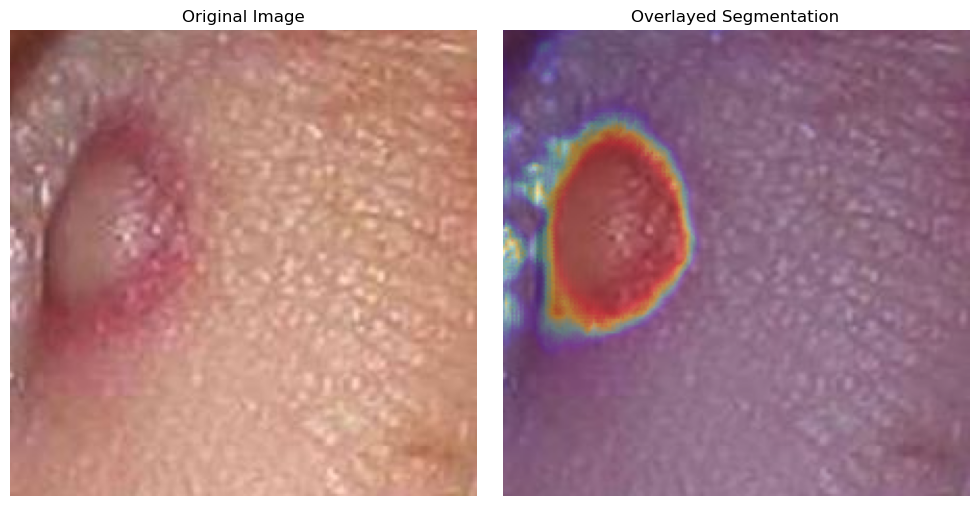

In [2]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import matplotlib.pyplot as plt

# Register custom metrics
@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)

@tf.keras.utils.register_keras_serializable()
def iou_coef(y_true, y_pred):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

# Load your pre-trained U-Net model with custom metrics
custom_objects = {"dice_coef": dice_coef, "iou_coef": iou_coef}
unet_model = load_model('best_unet_custom.keras', custom_objects=custom_objects)

# Symptom weights based on WHO guidelines
symptom_weights = {
    'Rectal Pain': 5,
    'Sore Throat': 4,
    'Penile Oedema': 6,
    'Oral Lesions': 7,
    'Solitary Lesion': 5,
    'Swollen Tonsils': 4,
    'HIV Infection': 8,
    'Sexually Transmitted Infection': 6,
    'Systemic Illness_Fever': 6,
    'Systemic Illness_Muscle Aches and Pain': 5,
    'Systemic Illness_Swollen Lymph Nodes': 7,
    'Systemic Illness_n/a': 0
}

# Severity thresholds for number of lesions
T1, T2, T3 = 5, 10, 17  # Updated severity thresholds
alpha, beta = 0.6, 0.4  # Lesion weight factors
gamma, delta = 0.5, 0.5  # Final score weights
N_max, A_max = 50, 100  # Maximum lesion and area values for normalization

# Function to calculate symptom severity score
def calculate_symptom_score(symptoms, symptom_weights):
    S_symptoms = sum(int(symptoms[symptom]) * symptom_weights[symptom] for symptom in symptoms)
    return (S_symptoms / sum(symptom_weights.values())) * 100

# Function to calculate lesion metrics
def calculate_lesion_size(predicted_mask, threshold=0.5):
    predicted_mask = np.clip(predicted_mask, 0, 1)
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    num_labels, labels_im = cv2.connectedComponents(binary_mask)
    lesion_sizes = [np.sum(labels_im == label) for label in range(1, num_labels)]
    total_lesion_area = np.sum(lesion_sizes)
    
    # Cap the maximum lesions to 50
    num_lesions = min(num_labels - 1, 50)
    
    return total_lesion_area, num_lesions, lesion_sizes

# Function to calculate image severity score
def calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta):
    S_image = alpha * (num_lesions / N_max) + beta * (total_lesion_area / A_max)
    return S_image * 100

# Function to calculate final severity score
def calculate_final_score(S_symptoms, S_image, gamma, delta):
    return gamma * S_symptoms + delta * S_image

# Function to determine severity level
def determine_severity_level(S_final, num_lesions):
    if num_lesions < T1:
        return "Mild"
    elif T1 <= num_lesions <= T2:
        return "Moderate"
    elif T2 < num_lesions <= T3:
        return "Severe"
    else:  # num_lesions > T3
        return "Serious"

# Function to process patient data and visualize results
def process_patient_data(image, symptoms, unet_model):
    # Predict lesion mask
    predicted_mask = unet_model.predict(np.expand_dims(image, axis=0))[0]
    
    # Calculate lesion metrics
    total_lesion_area, num_lesions, _ = calculate_lesion_size(predicted_mask)
    
    # Calculate scores
    S_symptoms = calculate_symptom_score(symptoms, symptom_weights)
    S_image = calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta)
    S_final = calculate_final_score(S_symptoms, S_image, gamma, delta)
    
    # Determine severity level
    severity_level = determine_severity_level(S_final, num_lesions)
    
    # Overlay the predicted mask on the original image
    overlayed_image = image.copy()
    mask_colored = cv2.applyColorMap((predicted_mask * 255).astype(np.uint8), cv2.COLORMAP_JET)
    overlayed_image = cv2.addWeighted(overlayed_image, 0.7, mask_colored, 0.3, 0)
    
    return S_symptoms, S_image, S_final, severity_level, overlayed_image

# Example patient data
symptoms = {
    'Rectal Pain': True,
    'Sore Throat': False,
    'Penile Oedema': False,
    'Oral Lesions': True,
    'Solitary Lesion': False,
    'Swollen Tonsils': False,
    'HIV Infection': False,
    'Sexually Transmitted Infection': False,
    'Systemic Illness_Fever': True,
    'Systemic Illness_Muscle Aches and Pain': True,
    'Systemic Illness_Swollen Lymph Nodes': False,
    'Systemic Illness_n/a': False
}

# Example image (preprocessed to match U-Net input dimensions)
image = cv2.imread('mkp_093.jpg')
image = cv2.resize(image, (224, 224))  # Resize to match model input size

# Process patient data
S_symptoms, S_image, S_final, severity_level, overlayed_image = process_patient_data(image, symptoms, unet_model)

# Display results
print(f"Symptom-Based Severity Score: {S_symptoms:.2f}")
print(f"Image-Based Severity Score: {S_image:.2f}")
print(f"Final Severity Score: {S_final:.2f}")
print(f"Severity Level: {severity_level}")

# Visualize the segmented image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Overlayed Segmentation")
plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
Symptom-Based Severity Score: 38.83
Image-Based Severity Score: 10.56
Final Severity Score: 24.70
Severity Level: Mild


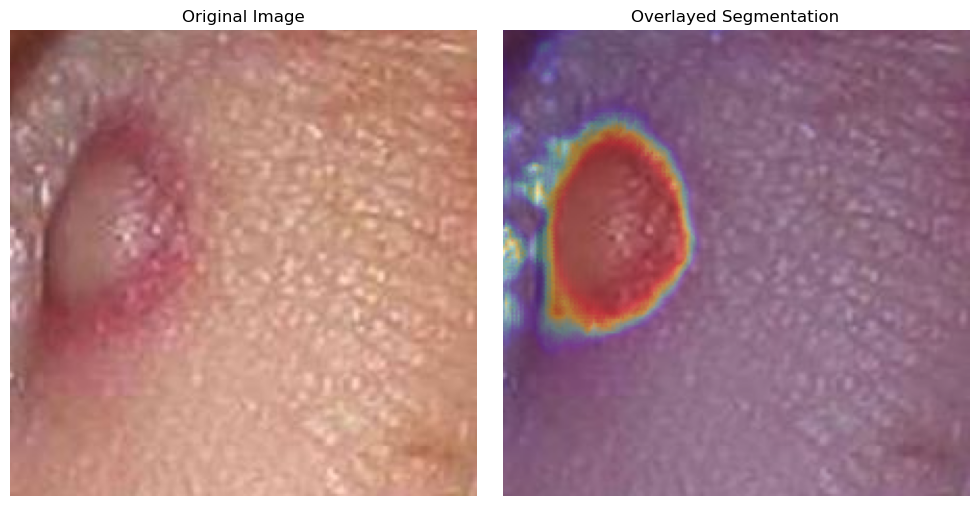

In [6]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Symptom weights and thresholds based on WHO guideline
symptom_weights = {
    'Rectal Pain': 10,
    'Sore Throat': 5,
    'Penile Oedema': 8,
    'Oral Lesions': 12,
    'Solitary Lesion': 7,
    'Swollen Tonsils': 6,
    'HIV Infection': 15,
    'Sexually Transmitted Infection': 10,
    'Systemic Illness_Fever': 10,
    'Systemic Illness_Muscle Aches and Pain': 8,
    'Systemic Illness_Swollen Lymph Nodes': 12,
    'Systemic Illness_n/a': 0
}

T1, T2, T3 = 25, 50, 75  # Severity thresholds for final score
alpha, beta = 0.6, 0.4  # Lesion weight factors
gamma, delta = 0.5, 0.5  # Final score weights
N_max, A_max = 50, 100000  # Maximum lesions and lesion area for normalization

# Function to calculate symptom severity score
def calculate_symptom_score(symptoms, symptom_weights):
    S_symptoms = sum(int(symptoms[symptom]) * symptom_weights[symptom] for symptom in symptoms)
    return (S_symptoms / sum(symptom_weights.values())) * 100

# Function to calculate lesion metrics
def calculate_lesion_size(predicted_mask, threshold=0.5):
    predicted_mask = np.clip(predicted_mask, 0, 1)
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    num_labels, labels_im = cv2.connectedComponents(binary_mask)
    lesion_sizes = [np.sum(labels_im == label) for label in range(1, num_labels)]
    total_lesion_area = np.sum(lesion_sizes)
    return total_lesion_area, num_labels - 1, lesion_sizes

# Function to calculate normalized image-based severity score
def calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta):
    num_lesions_norm = min(num_lesions / N_max, 1.0)  # Normalize and cap to 1.0
    lesion_area_norm = min(total_lesion_area / A_max, 1.0)  # Normalize and cap to 1.0
    S_image = 100 * (alpha * num_lesions_norm + beta * lesion_area_norm)
    return S_image

# Function to calculate final normalized severity score
def calculate_final_score(S_symptoms, S_image, gamma, delta):
    S_final = gamma * S_symptoms + delta * S_image
    return min(S_final, 100)

# Function to determine severity level
def determine_severity_level(S_final, T1, T2, T3):
    if S_final < T1:
        return "Mild"
    elif T1 <= S_final < T2:
        return "Moderate"
    elif T2 <= S_final < T3:
        return "Severe"
    else:
        return "Serious"

# Function to process patient data and calculate severity
def process_patient_data(image, symptoms, unet_model):
    # Predict lesion mask
    predicted_mask = unet_model.predict(np.expand_dims(image, axis=0))[0]
    
    # Calculate lesion metrics
    total_lesion_area, num_lesions, _ = calculate_lesion_size(predicted_mask)
    
    # Calculate scores
    S_symptoms = calculate_symptom_score(symptoms, symptom_weights)
    S_image = calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta)
    S_final = calculate_final_score(S_symptoms, S_image, gamma, delta)
    
    # Determine severity level
    severity_level = determine_severity_level(S_final, T1, T2, T3)
    
    return S_symptoms, S_image, S_final, severity_level, predicted_mask

# Load pre-trained U-Net model
unet_model = load_model('best_unet_custom.keras')

# Example patient data
symptoms = {
    'Rectal Pain': True,
    'Sore Throat': False,
    'Penile Oedema': False,
    'Oral Lesions': True,
    'Solitary Lesion': False,
    'Swollen Tonsils': False,
    'HIV Infection': False,
    'Sexually Transmitted Infection': False,
    'Systemic Illness_Fever': True,
    'Systemic Illness_Muscle Aches and Pain': True,
    'Systemic Illness_Swollen Lymph Nodes': False,
    'Systemic Illness_n/a': False
}

# Example image (preprocessed to match U-Net input dimensions)
image = cv2.imread('mkp_093.jpg')
image = cv2.resize(image, (224, 224))  # Resize to match model input size

# Process patient data
S_symptoms, S_image, S_final, severity_level, predicted_mask = process_patient_data(image, symptoms, unet_model)

# Display results
print(f"Symptom-Based Severity Score: {S_symptoms:.2f}")
print(f"Image-Based Severity Score: {S_image:.2f}")
print(f"Final Severity Score: {S_final:.2f}")
print(f"Severity Level: {severity_level}")

# Visualize the segmented image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Overlayed Segmentation")
plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
Number of lesions detected: 7


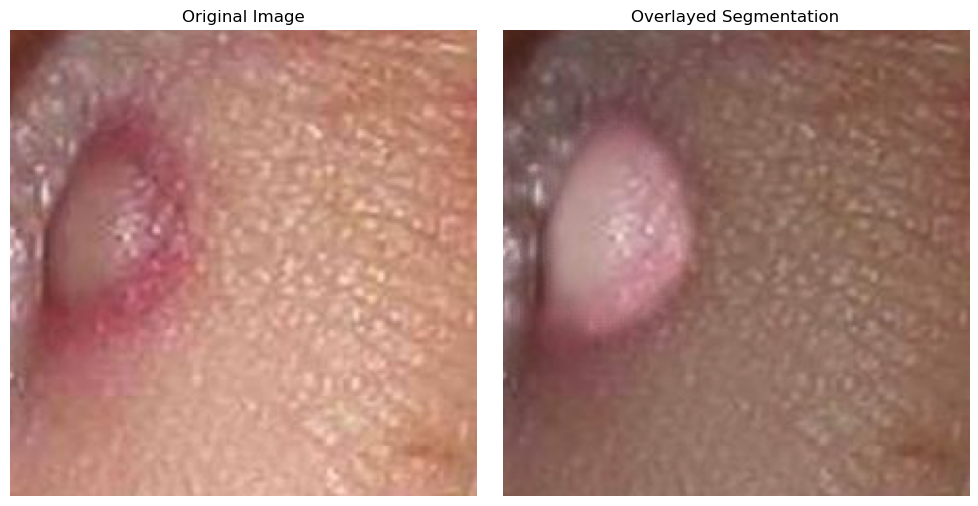

In [12]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt



# Register custom metrics
@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)

@tf.keras.utils.register_keras_serializable()
def iou_coef(y_true, y_pred):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

# Load your pre-trained U-Net model with custom metrics
custom_objects = {"dice_coef": dice_coef, "iou_coef": iou_coef}
unet_model = load_model('best_unet_custom.keras', custom_objects=custom_objects)

# Symptom weights and thresholds based on WHO guideline
symptom_weights = {
    'Rectal Pain': 10,
    'Sore Throat': 5,
    'Penile Oedema': 8,
    'Oral Lesions': 12,
    'Solitary Lesion': 7,
    'Swollen Tonsils': 6,
    'HIV Infection': 15,
    'Sexually Transmitted Infection': 10,
    'Systemic Illness_Fever': 10,
    'Systemic Illness_Muscle Aches and Pain': 8,
    'Systemic Illness_Swollen Lymph Nodes': 12,
    'Systemic Illness_n/a': 0
}

T1, T2, T3 = 25, 50, 75  # Severity thresholds for final score
alpha, beta = 0.6, 0.4  # Lesion weight factors
gamma, delta = 0.5, 0.5  # Final score weights
N_max, A_max = 50, 100000  # Maximum lesions and lesion area for normalization

# Function to calculate symptom severity score
def calculate_symptom_score(symptoms, symptom_weights):
    S_symptoms = sum(int(symptoms[symptom]) * symptom_weights[symptom] for symptom in symptoms)
    return (S_symptoms / sum(symptom_weights.values())) * 100

# Function to calculate lesion metrics
def calculate_lesion_size(predicted_mask, threshold=0.5):
    predicted_mask = np.clip(predicted_mask, 0, 1)
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    num_labels, labels_im = cv2.connectedComponents(binary_mask)
    lesion_sizes = [np.sum(labels_im == label) for label in range(1, num_labels)]
    total_lesion_area = np.sum(lesion_sizes)
    return total_lesion_area, num_labels - 1, lesion_sizes

# Function to calculate normalized image-based severity score
def calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta):
    num_lesions_norm = min(num_lesions / N_max, 1.0)  # Normalize and cap to 1.0
    lesion_area_norm = min(total_lesion_area / A_max, 1.0)  # Normalize and cap to 1.0
    S_image = 100 * (alpha * num_lesions_norm + beta * lesion_area_norm)
    return S_image

# Function to calculate final normalized severity score
def calculate_final_score(S_symptoms, S_image, gamma, delta):
    S_final = gamma * S_symptoms + delta * S_image
    return min(S_final, 100)

# Function to determine severity level
def determine_severity_level(S_final, T1, T2, T3):
    if S_final < T1:
        return "Mild"
    elif T1 <= S_final < T2:
        return "Moderate"
    elif T2 <= S_final < T3:
        return "Severe"
    else:
        return "Serious"

def process_patient_data(image, symptoms, unet_model):
    # Predict lesion mask
    predicted_mask = unet_model.predict(np.expand_dims(image, axis=0))[0]
    
    # Calculate lesion metrics
    total_lesion_area, num_lesions, _ = calculate_lesion_size(predicted_mask)
    
    # Calculate scores
    S_symptoms = calculate_symptom_score(symptoms, symptom_weights)
    S_image = calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta)
    S_final = calculate_final_score(S_symptoms, S_image, gamma, delta)
    
    # Determine severity level
    severity_level = determine_severity_level(S_final, T1, T2, T3)
    
    # Also return num_lesions
    return S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions


# Load pre-trained U-Net model
unet_model = load_model('best_unet_custom.keras')

# Example patient data
symptoms = {
    'Rectal Pain': True,
    'Sore Throat': False,
    'Penile Oedema': False,
    'Oral Lesions': True,
    'Solitary Lesion': False,
    'Swollen Tonsils': False,
    'HIV Infection': False,
    'Sexually Transmitted Infection': False,
    'Systemic Illness_Fever': True,
    'Systemic Illness_Muscle Aches and Pain': True,
    'Systemic Illness_Swollen Lymph Nodes': False,
    'Systemic Illness_n/a': False
}

# Example image (preprocessed to match U-Net input dimensions)
image = cv2.imread('mkp_093.jpg')
image = cv2.resize(image, (224, 224))  # Resize to match model input size

# Process patient data
S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions = process_patient_data(image, symptoms, unet_model)


# Threshold the predicted mask (make it binary 0 or 255)
binary_mask = (predicted_mask > 0.5).astype(np.uint8)

# Find connected components (each lesion = 1 component)
num_labels, labels_im = cv2.connectedComponents(binary_mask)

# Subtract 1 because label 0 is background
num_lesions = num_labels - 1

print(f"Number of lesions detected: {num_lesions}")



plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Overlayed Segmentation")

# Corrected mask processing
predicted_mask_rescaled = (predicted_mask * 255).astype(np.uint8)
mask_3ch = cv2.merge([predicted_mask_rescaled]*3)

overlayed_image = cv2.addWeighted(image, 0.7, mask_3ch, 0.3, 0)
plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
Number of lesions detected: 7
Symptom Score: 38.83
Image Score: 10.56
Final Severity Score: 24.70
Severity Level: Mild


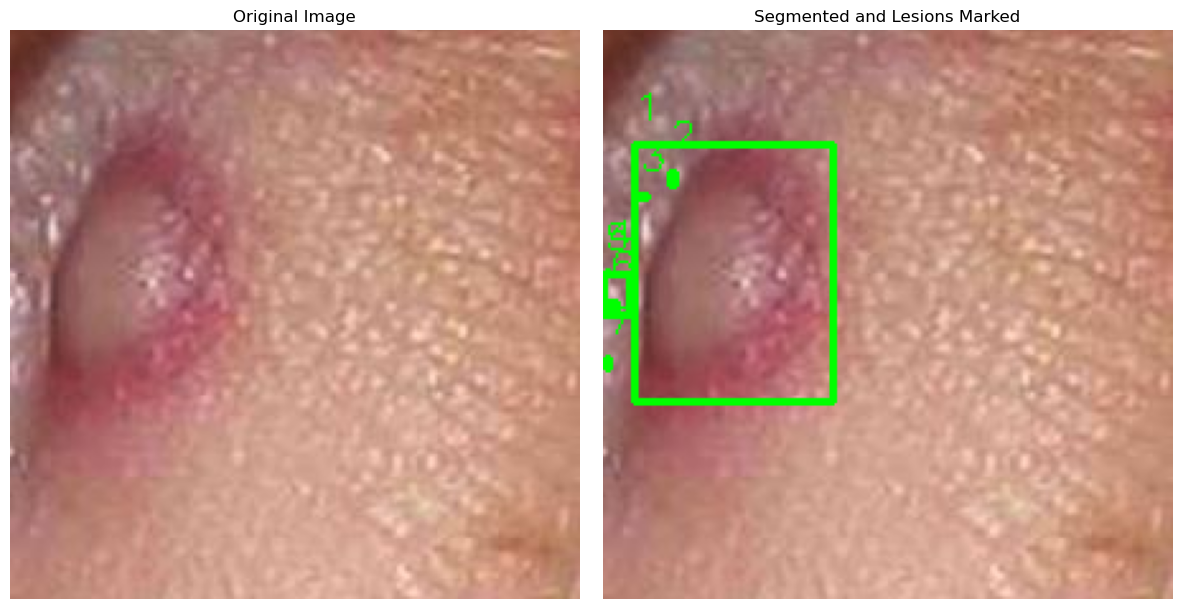

In [13]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Register custom metrics
@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)

@tf.keras.utils.register_keras_serializable()
def iou_coef(y_true, y_pred):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

# Load pre-trained U-Net model
custom_objects = {"dice_coef": dice_coef, "iou_coef": iou_coef}
unet_model = load_model('best_unet_custom.keras', custom_objects=custom_objects)

# Symptom weights and thresholds based on WHO guideline
symptom_weights = {
    'Rectal Pain': 10,
    'Sore Throat': 5,
    'Penile Oedema': 8,
    'Oral Lesions': 12,
    'Solitary Lesion': 7,
    'Swollen Tonsils': 6,
    'HIV Infection': 15,
    'Sexually Transmitted Infection': 10,
    'Systemic Illness_Fever': 10,
    'Systemic Illness_Muscle Aches and Pain': 8,
    'Systemic Illness_Swollen Lymph Nodes': 12,
    'Systemic Illness_n/a': 0
}

T1, T2, T3 = 25, 50, 75  # Severity thresholds
alpha, beta = 0.6, 0.4   # Lesion weight factors
gamma, delta = 0.5, 0.5  # Final score weights
N_max, A_max = 50, 100000

# Function to calculate symptom severity score
def calculate_symptom_score(symptoms, symptom_weights):
    S_symptoms = sum(int(symptoms[symptom]) * symptom_weights[symptom] for symptom in symptoms)
    return (S_symptoms / sum(symptom_weights.values())) * 100

# Function to calculate lesion size
def calculate_lesion_size(predicted_mask, threshold=0.5):
    predicted_mask = np.clip(predicted_mask, 0, 1)
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    num_labels, labels_im = cv2.connectedComponents(binary_mask)
    lesion_sizes = [np.sum(labels_im == label) for label in range(1, num_labels)]
    total_lesion_area = np.sum(lesion_sizes)
    return total_lesion_area, num_labels - 1, lesion_sizes, labels_im

# Function to calculate normalized image-based severity score
def calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta):
    num_lesions_norm = min(num_lesions / N_max, 1.0)
    lesion_area_norm = min(total_lesion_area / A_max, 1.0)
    S_image = 100 * (alpha * num_lesions_norm + beta * lesion_area_norm)
    return S_image

# Function to calculate final normalized severity score
def calculate_final_score(S_symptoms, S_image, gamma, delta):
    S_final = gamma * S_symptoms + delta * S_image
    return min(S_final, 100)

# Function to determine severity level
def determine_severity_level(S_final, T1, T2, T3):
    if S_final < T1:
        return "Mild"
    elif T1 <= S_final < T2:
        return "Moderate"
    elif T2 <= S_final < T3:
        return "Severe"
    else:
        return "Serious"

def process_patient_data(image, symptoms, unet_model):
    predicted_mask = unet_model.predict(np.expand_dims(image, axis=0))[0]
    total_lesion_area, num_lesions, lesion_sizes, labels_im = calculate_lesion_size(predicted_mask)
    S_symptoms = calculate_symptom_score(symptoms, symptom_weights)
    S_image = calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta)
    S_final = calculate_final_score(S_symptoms, S_image, gamma, delta)
    severity_level = determine_severity_level(S_final, T1, T2, T3)
    return S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions, labels_im

# Example patient data
symptoms = {
    'Rectal Pain': True,
    'Sore Throat': False,
    'Penile Oedema': False,
    'Oral Lesions': True,
    'Solitary Lesion': False,
    'Swollen Tonsils': False,
    'HIV Infection': False,
    'Sexually Transmitted Infection': False,
    'Systemic Illness_Fever': True,
    'Systemic Illness_Muscle Aches and Pain': True,
    'Systemic Illness_Swollen Lymph Nodes': False,
    'Systemic Illness_n/a': False
}

# Example image
image = cv2.imread('mkp_093.jpg')
image = cv2.resize(image, (224, 224))

# Process patient data
S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions, labels_im = process_patient_data(image, symptoms, unet_model)

# Threshold the predicted mask
binary_mask = (predicted_mask > 0.5).astype(np.uint8)

# Find connected components
num_labels, labels = cv2.connectedComponents(binary_mask)

# Visualization
overlay_image = image.copy()

for label in range(1, num_labels):  # Skip label 0 (background)
    mask = (labels == label).astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(overlay_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(overlay_image, f'{label}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

print(f"Number of lesions detected: {num_lesions}")
print(f"Symptom Score: {S_symptoms:.2f}")
print(f"Image Score: {S_image:.2f}")
print(f"Final Severity Score: {S_final:.2f}")
print(f"Severity Level: {severity_level}")

# Display
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Segmented and Lesions Marked")
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
Number of lesions detected: 6
Symptom Score: 38.83
Image Score: 8.27
Final Severity Score: 23.55
Severity Level: Mild


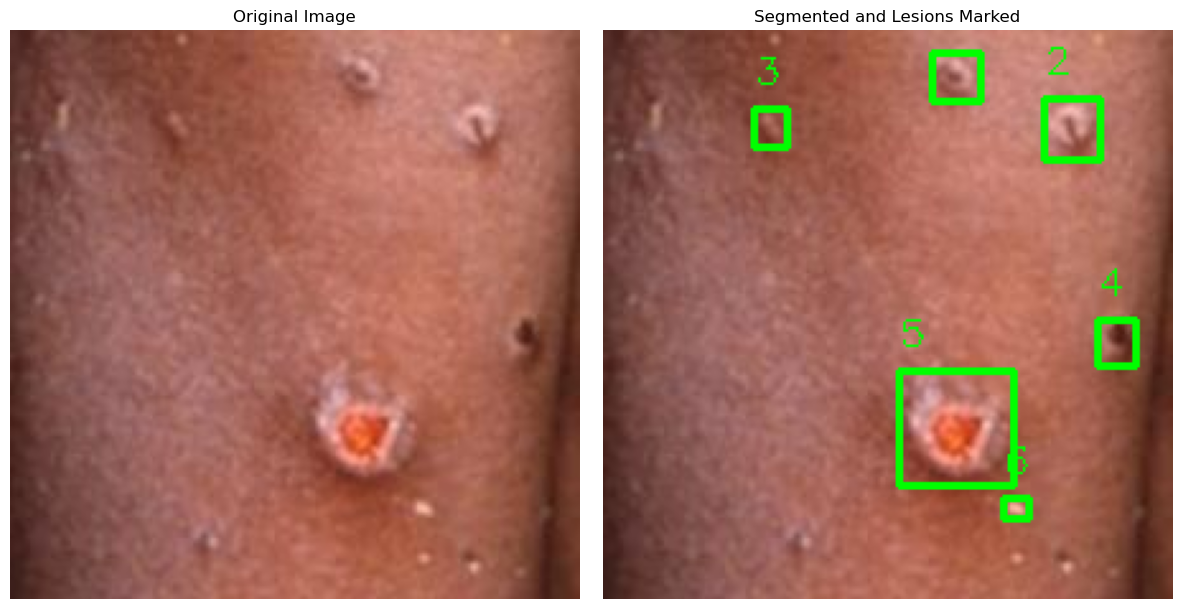

In [14]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Register custom metrics
@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)

@tf.keras.utils.register_keras_serializable()
def iou_coef(y_true, y_pred):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

# Load pre-trained U-Net model
custom_objects = {"dice_coef": dice_coef, "iou_coef": iou_coef}
unet_model = load_model('best_unet_custom.keras', custom_objects=custom_objects)

# Symptom weights and thresholds based on WHO guideline
symptom_weights = {
    'Rectal Pain': 10,
    'Sore Throat': 5,
    'Penile Oedema': 8,
    'Oral Lesions': 12,
    'Solitary Lesion': 7,
    'Swollen Tonsils': 6,
    'HIV Infection': 15,
    'Sexually Transmitted Infection': 10,
    'Systemic Illness_Fever': 10,
    'Systemic Illness_Muscle Aches and Pain': 8,
    'Systemic Illness_Swollen Lymph Nodes': 12,
    'Systemic Illness_n/a': 0
}

T1, T2, T3 = 25, 50, 75  # Severity thresholds
alpha, beta = 0.6, 0.4   # Lesion weight factors
gamma, delta = 0.5, 0.5  # Final score weights
N_max, A_max = 50, 100000

# Function to calculate symptom severity score
def calculate_symptom_score(symptoms, symptom_weights):
    S_symptoms = sum(int(symptoms[symptom]) * symptom_weights[symptom] for symptom in symptoms)
    return (S_symptoms / sum(symptom_weights.values())) * 100

# Function to calculate lesion size
def calculate_lesion_size(predicted_mask, threshold=0.5):
    predicted_mask = np.clip(predicted_mask, 0, 1)
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    num_labels, labels_im = cv2.connectedComponents(binary_mask)
    lesion_sizes = [np.sum(labels_im == label) for label in range(1, num_labels)]
    total_lesion_area = np.sum(lesion_sizes)
    return total_lesion_area, num_labels - 1, lesion_sizes, labels_im

# Function to calculate normalized image-based severity score
def calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta):
    num_lesions_norm = min(num_lesions / N_max, 1.0)
    lesion_area_norm = min(total_lesion_area / A_max, 1.0)
    S_image = 100 * (alpha * num_lesions_norm + beta * lesion_area_norm)
    return S_image

# Function to calculate final normalized severity score
def calculate_final_score(S_symptoms, S_image, gamma, delta):
    S_final = gamma * S_symptoms + delta * S_image
    return min(S_final, 100)

# Function to determine severity level
def determine_severity_level(S_final, T1, T2, T3):
    if S_final < T1:
        return "Mild"
    elif T1 <= S_final < T2:
        return "Moderate"
    elif T2 <= S_final < T3:
        return "Severe"
    else:
        return "Serious"

def process_patient_data(image, symptoms, unet_model):
    predicted_mask = unet_model.predict(np.expand_dims(image, axis=0))[0]
    total_lesion_area, num_lesions, lesion_sizes, labels_im = calculate_lesion_size(predicted_mask)
    S_symptoms = calculate_symptom_score(symptoms, symptom_weights)
    S_image = calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta)
    S_final = calculate_final_score(S_symptoms, S_image, gamma, delta)
    severity_level = determine_severity_level(S_final, T1, T2, T3)
    return S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions, labels_im

# Example patient data
symptoms = {
    'Rectal Pain': True,
    'Sore Throat': False,
    'Penile Oedema': False,
    'Oral Lesions': True,
    'Solitary Lesion': False,
    'Swollen Tonsils': False,
    'HIV Infection': False,
    'Sexually Transmitted Infection': False,
    'Systemic Illness_Fever': True,
    'Systemic Illness_Muscle Aches and Pain': True,
    'Systemic Illness_Swollen Lymph Nodes': False,
    'Systemic Illness_n/a': False
}

# Example image
image = cv2.imread('mkp_078.jpg')
image = cv2.resize(image, (224, 224))

# Process patient data
S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions, labels_im = process_patient_data(image, symptoms, unet_model)

# Threshold the predicted mask
binary_mask = (predicted_mask > 0.5).astype(np.uint8)

# Find connected components
num_labels, labels = cv2.connectedComponents(binary_mask)

# Visualization
overlay_image = image.copy()

for label in range(1, num_labels):  # Skip label 0 (background)
    mask = (labels == label).astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(overlay_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(overlay_image, f'{label}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

print(f"Number of lesions detected: {num_lesions}")
print(f"Symptom Score: {S_symptoms:.2f}")
print(f"Image Score: {S_image:.2f}")
print(f"Final Severity Score: {S_final:.2f}")
print(f"Severity Level: {severity_level}")

# Display
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Segmented and Lesions Marked")
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
Number of lesions detected: 15
Symptom Score: 38.83
Image Score: 19.33
Final Severity Score: 29.08
Severity Level: Moderate


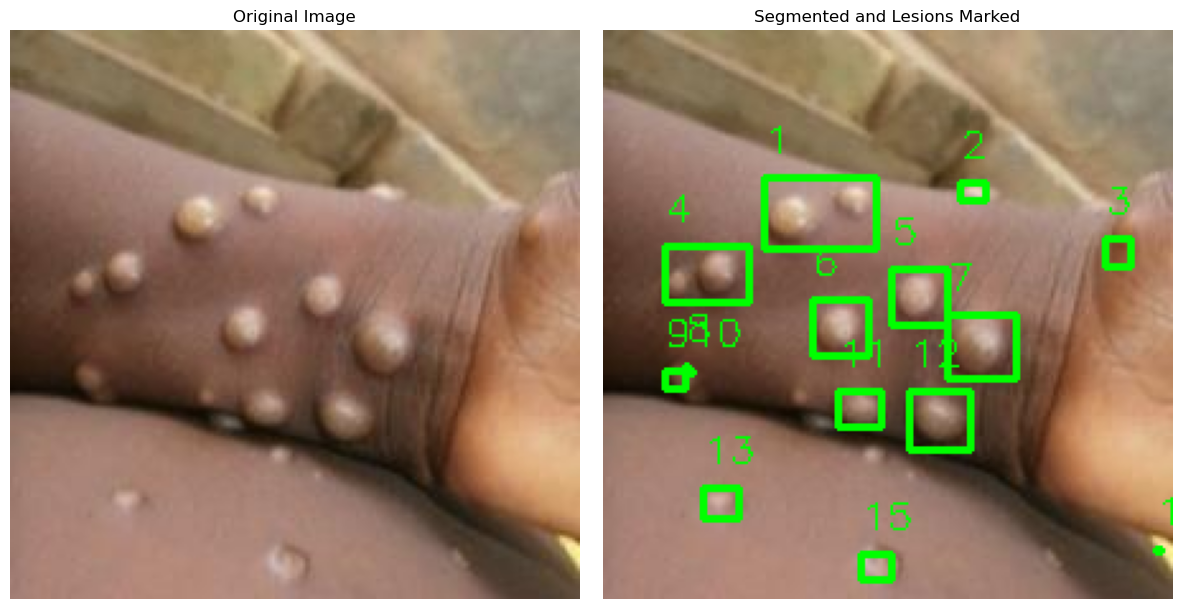

In [15]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Register custom metrics
@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)

@tf.keras.utils.register_keras_serializable()
def iou_coef(y_true, y_pred):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

# Load pre-trained U-Net model
custom_objects = {"dice_coef": dice_coef, "iou_coef": iou_coef}
unet_model = load_model('best_unet_custom.keras', custom_objects=custom_objects)

# Symptom weights and thresholds based on WHO guideline
symptom_weights = {
    'Rectal Pain': 10,
    'Sore Throat': 5,
    'Penile Oedema': 8,
    'Oral Lesions': 12,
    'Solitary Lesion': 7,
    'Swollen Tonsils': 6,
    'HIV Infection': 15,
    'Sexually Transmitted Infection': 10,
    'Systemic Illness_Fever': 10,
    'Systemic Illness_Muscle Aches and Pain': 8,
    'Systemic Illness_Swollen Lymph Nodes': 12,
    'Systemic Illness_n/a': 0
}

T1, T2, T3 = 25, 50, 75  # Severity thresholds
alpha, beta = 0.6, 0.4   # Lesion weight factors
gamma, delta = 0.5, 0.5  # Final score weights
N_max, A_max = 50, 100000

# Function to calculate symptom severity score
def calculate_symptom_score(symptoms, symptom_weights):
    S_symptoms = sum(int(symptoms[symptom]) * symptom_weights[symptom] for symptom in symptoms)
    return (S_symptoms / sum(symptom_weights.values())) * 100

# Function to calculate lesion size
def calculate_lesion_size(predicted_mask, threshold=0.5):
    predicted_mask = np.clip(predicted_mask, 0, 1)
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    num_labels, labels_im = cv2.connectedComponents(binary_mask)
    lesion_sizes = [np.sum(labels_im == label) for label in range(1, num_labels)]
    total_lesion_area = np.sum(lesion_sizes)
    return total_lesion_area, num_labels - 1, lesion_sizes, labels_im

# Function to calculate normalized image-based severity score
def calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta):
    num_lesions_norm = min(num_lesions / N_max, 1.0)
    lesion_area_norm = min(total_lesion_area / A_max, 1.0)
    S_image = 100 * (alpha * num_lesions_norm + beta * lesion_area_norm)
    return S_image

# Function to calculate final normalized severity score
def calculate_final_score(S_symptoms, S_image, gamma, delta):
    S_final = gamma * S_symptoms + delta * S_image
    return min(S_final, 100)

# Function to determine severity level
def determine_severity_level(S_final, T1, T2, T3):
    if S_final < T1:
        return "Mild"
    elif T1 <= S_final < T2:
        return "Moderate"
    elif T2 <= S_final < T3:
        return "Severe"
    else:
        return "Serious"

def process_patient_data(image, symptoms, unet_model):
    predicted_mask = unet_model.predict(np.expand_dims(image, axis=0))[0]
    total_lesion_area, num_lesions, lesion_sizes, labels_im = calculate_lesion_size(predicted_mask)
    S_symptoms = calculate_symptom_score(symptoms, symptom_weights)
    S_image = calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta)
    S_final = calculate_final_score(S_symptoms, S_image, gamma, delta)
    severity_level = determine_severity_level(S_final, T1, T2, T3)
    return S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions, labels_im

# Example patient data
symptoms = {
    'Rectal Pain': True,
    'Sore Throat': False,
    'Penile Oedema': False,
    'Oral Lesions': True,
    'Solitary Lesion': False,
    'Swollen Tonsils': False,
    'HIV Infection': False,
    'Sexually Transmitted Infection': False,
    'Systemic Illness_Fever': True,
    'Systemic Illness_Muscle Aches and Pain': True,
    'Systemic Illness_Swollen Lymph Nodes': False,
    'Systemic Illness_n/a': False
}

# Example image
image = cv2.imread('mkp_047.jpg')
image = cv2.resize(image, (224, 224))

# Process patient data
S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions, labels_im = process_patient_data(image, symptoms, unet_model)

# Threshold the predicted mask
binary_mask = (predicted_mask > 0.5).astype(np.uint8)

# Find connected components
num_labels, labels = cv2.connectedComponents(binary_mask)

# Visualization
overlay_image = image.copy()

for label in range(1, num_labels):  # Skip label 0 (background)
    mask = (labels == label).astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(overlay_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(overlay_image, f'{label}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

print(f"Number of lesions detected: {num_lesions}")
print(f"Symptom Score: {S_symptoms:.2f}")
print(f"Image Score: {S_image:.2f}")
print(f"Final Severity Score: {S_final:.2f}")
print(f"Severity Level: {severity_level}")

# Display
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Segmented and Lesions Marked")
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
Symptom-Based Severity Score: 38.83
Image-Based Severity Score: 19.33
Final Severity Score: 27.13
Severity Level: Moderate


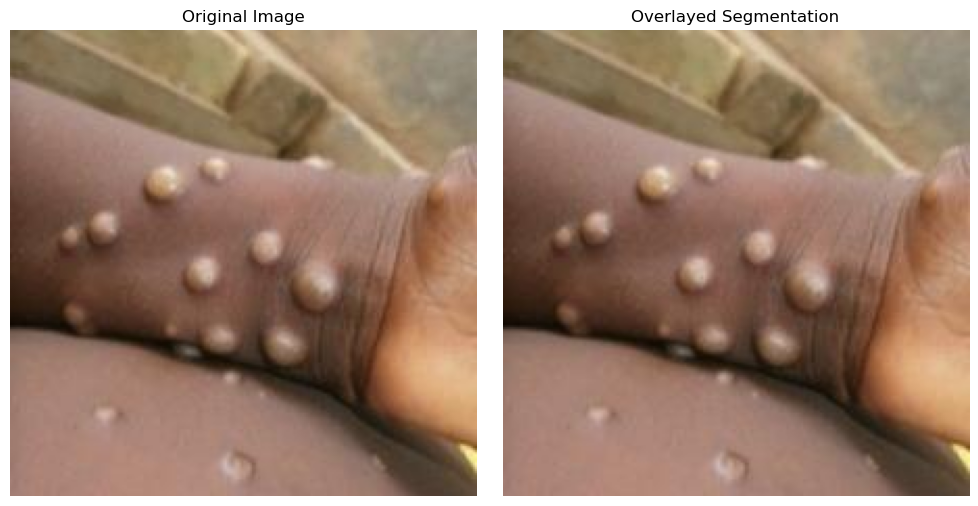

In [34]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Symptom weights and thresholds based on WHO guideline
symptom_weights = {
    'Rectal Pain': 10,
    'Sore Throat': 5,
    'Penile Oedema': 8,
    'Oral Lesions': 12,
    'Solitary Lesion': 7,
    'Swollen Tonsils': 6,
    'HIV Infection': 15,
    'Sexually Transmitted Infection': 10,
    'Systemic Illness_Fever': 10,
    'Systemic Illness_Muscle Aches and Pain': 8,
    'Systemic Illness_Swollen Lymph Nodes': 12,
    'Systemic Illness_n/a': 0
}

T1, T2, T3 = 25, 50, 75  # Severity thresholds for final score
alpha, beta = 0.6, 0.4  # Lesion weight factors
gamma, delta = 0.4, 0.6  # Final score weights
N_max, A_max = 50, 100000  # Maximum lesions and lesion area for normalization

# Function to calculate symptom severity score
def calculate_symptom_score(symptoms, symptom_weights):
    S_symptoms = sum(int(symptoms[symptom]) * symptom_weights[symptom] for symptom in symptoms)
    return (S_symptoms / sum(symptom_weights.values())) * 100

# Function to calculate lesion metrics
def calculate_lesion_size(predicted_mask, threshold=0.5):
    predicted_mask = np.clip(predicted_mask, 0, 1)
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    num_labels, labels_im = cv2.connectedComponents(binary_mask)
    lesion_sizes = [np.sum(labels_im == label) for label in range(1, num_labels)]
    total_lesion_area = np.sum(lesion_sizes)
    return total_lesion_area, num_labels - 1, lesion_sizes

# Function to calculate normalized image-based severity score
def calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta):
    num_lesions_norm = min(num_lesions / N_max, 1.0)  # Normalize and cap to 1.0
    lesion_area_norm = min(total_lesion_area / A_max, 1.0)  # Normalize and cap to 1.0
    S_image = 100 * (alpha * num_lesions_norm + beta * lesion_area_norm)
    return S_image

# Function to calculate final normalized severity score
def calculate_final_score(S_symptoms, S_image, gamma, delta):
    S_final = gamma * S_symptoms + delta * S_image
    return min(S_final, 100)

# Function to determine severity level
def determine_severity_level(S_final, T1, T2, T3):
    if S_final < T1:
        return "Mild"
    elif T1 <= S_final < T2:
        return "Moderate"
    elif T2 <= S_final < T3:
        return "Severe"
    else:
        return "Serious"

# Function to process patient data and calculate severity
def process_patient_data(image, symptoms, unet_model):
    # Predict lesion mask
    predicted_mask = unet_model.predict(np.expand_dims(image, axis=0))[0]
    
    # Calculate lesion metrics
    total_lesion_area, num_lesions, _ = calculate_lesion_size(predicted_mask)
    
    # Calculate scores
    S_symptoms = calculate_symptom_score(symptoms, symptom_weights)
    S_image = calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta)
    S_final = calculate_final_score(S_symptoms, S_image, gamma, delta)
    
    # Determine severity level
    severity_level = determine_severity_level(S_final, T1, T2, T3)
    
    return S_symptoms, S_image, S_final, severity_level, predicted_mask

# Load pre-trained U-Net model
unet_model = load_model('best_unet_custom.keras')

# Example patient data
symptoms = {
    'Rectal Pain': True,
    'Sore Throat': False,
    'Penile Oedema': False,
    'Oral Lesions': True,
    'Solitary Lesion': False,
    'Swollen Tonsils': False,
    'HIV Infection': False,
    'Sexually Transmitted Infection': False,
    'Systemic Illness_Fever': True,
    'Systemic Illness_Muscle Aches and Pain': True,
    'Systemic Illness_Swollen Lymph Nodes': False,
    'Systemic Illness_n/a': False
}

# Example image (preprocessed to match U-Net input dimensions)
image = cv2.imread('mkp_047.jpg')
image = cv2.resize(image, (224, 224))  # Resize to match model input size
overlayed_image = image.copy()

# Process patient data
S_symptoms, S_image, S_final, severity_level, predicted_mask = process_patient_data(image, symptoms, unet_model)

# Display results
print(f"Symptom-Based Severity Score: {S_symptoms:.2f}")
print(f"Image-Based Severity Score: {S_image:.2f}")
print(f"Final Severity Score: {S_final:.2f}")
print(f"Severity Level: {severity_level}")

# Visualize the segmented image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Overlayed Segmentation")
plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
Symptom-Based Severity Score: 36.51
Image-Based Severity Score: 7456.00
Final Severity Score: 3746.25
Severity Level: Severe


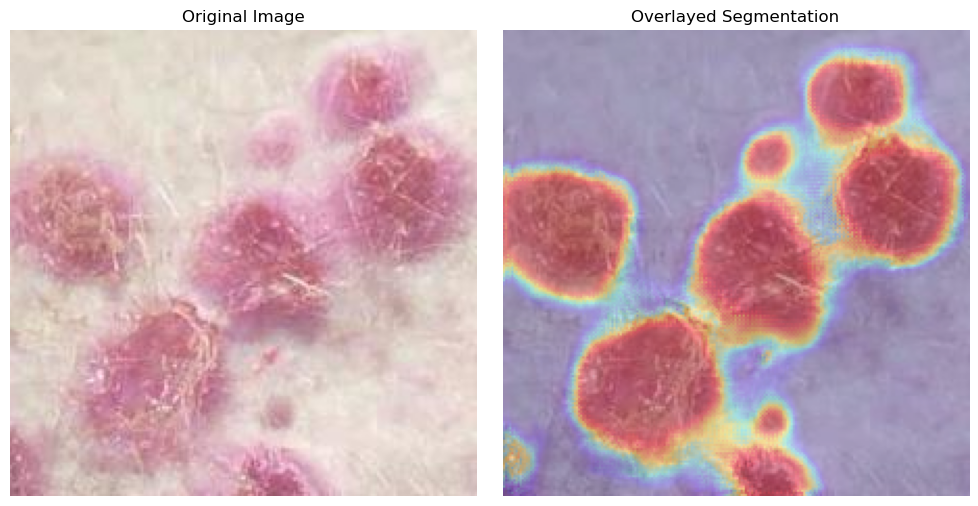

In [23]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import matplotlib.pyplot as plt

# Register custom metrics
@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)

@tf.keras.utils.register_keras_serializable()
def iou_coef(y_true, y_pred):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

# Load your pre-trained U-Net model with custom metrics
custom_objects = {"dice_coef": dice_coef, "iou_coef": iou_coef}
unet_model = load_model('best_unet_custom.keras', custom_objects=custom_objects)

# Symptom weights based on WHO guidelines
symptom_weights = {
    'Rectal Pain': 5,
    'Sore Throat': 4,
    'Penile Oedema': 6,
    'Oral Lesions': 7,
    'Solitary Lesion': 5,
    'Swollen Tonsils': 4,
    'HIV Infection': 8,
    'Sexually Transmitted Infection': 6,
    'Systemic Illness_Fever': 6,
    'Systemic Illness_Muscle Aches and Pain': 5,
    'Systemic Illness_Swollen Lymph Nodes': 7,
    'Systemic Illness_n/a': 0
}

# Severity thresholds for number of lesions
T1, T2, T3 = 5, 10, 17  # Updated severity thresholds
alpha, beta = 0.6, 0.4  # Lesion weight factors
gamma, delta = 0.5, 0.5  # Final score weights
N_max, A_max = 50, 100  # Maximum lesion and area values for normalization

# Function to calculate symptom severity score
def calculate_symptom_score(symptoms, symptom_weights):
    S_symptoms = sum(int(symptoms[symptom]) * symptom_weights[symptom] for symptom in symptoms)
    return (S_symptoms / sum(symptom_weights.values())) * 100

# Function to calculate lesion metrics
def calculate_lesion_size(predicted_mask, threshold=0.5):
    predicted_mask = np.clip(predicted_mask, 0, 1)
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    num_labels, labels_im = cv2.connectedComponents(binary_mask)
    lesion_sizes = [np.sum(labels_im == label) for label in range(1, num_labels)]
    total_lesion_area = np.sum(lesion_sizes)
    
    # Cap the maximum lesions to 50
    num_lesions = min(num_labels - 1, 50)
    
    return total_lesion_area, num_lesions, lesion_sizes

# Function to calculate image severity score
def calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta):
    S_image = alpha * (num_lesions / N_max) + beta * (total_lesion_area / A_max)
    return S_image * 100

# Function to calculate final severity score
def calculate_final_score(S_symptoms, S_image, gamma, delta):
    return gamma * S_symptoms + delta * S_image

# Function to determine severity level
def determine_severity_level(S_final, num_lesions):
    if num_lesions < T1:
        return "Mild"
    elif T1 <= num_lesions <= T2:
        return "Moderate"
    elif T2 < num_lesions <= T3:
        return "Severe"
    else:  # num_lesions > T3
        return "Serious"

# Function to process patient data and visualize results
def process_patient_data(image, symptoms, unet_model):
    # Predict lesion mask
    predicted_mask = unet_model.predict(np.expand_dims(image, axis=0))[0]
    
    # Calculate lesion metrics
    total_lesion_area, num_lesions, _ = calculate_lesion_size(predicted_mask)
    
    # Calculate scores
    S_symptoms = calculate_symptom_score(symptoms, symptom_weights)
    S_image = calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta)
    S_final = calculate_final_score(S_symptoms, S_image, gamma, delta)
    
    # Determine severity level
    severity_level = determine_severity_level(S_final, num_lesions)
    
    # Overlay the predicted mask on the original image
    overlayed_image = image.copy()
    mask_colored = cv2.applyColorMap((predicted_mask * 255).astype(np.uint8), cv2.COLORMAP_JET)
    overlayed_image = cv2.addWeighted(overlayed_image, 0.7, mask_colored, 0.3, 0)
    
    return S_symptoms, S_image, S_final, severity_level, overlayed_image

# Example patient data
symptoms = {
    'Rectal Pain': True,
    'Sore Throat': False,
    'Penile Oedema': False,
    'Oral Lesions': True,
    'Solitary Lesion': False,
    'Swollen Tonsils': False,
    'HIV Infection': False,
    'Sexually Transmitted Infection': False,
    'Systemic Illness_Fever': True,
    'Systemic Illness_Muscle Aches and Pain': True,
    'Systemic Illness_Swollen Lymph Nodes': False,
    'Systemic Illness_n/a': False
}

# Example image (preprocessed to match U-Net input dimensions)
image = cv2.imread('mkp_058.jpg')
image = cv2.resize(image, (224, 224))  # Resize to match model input size

# Process patient data
S_symptoms, S_image, S_final, severity_level, overlayed_image = process_patient_data(image, symptoms, unet_model)

# Display results
print(f"Symptom-Based Severity Score: {S_symptoms:.2f}")
print(f"Image-Based Severity Score: {S_image:.2f}")
print(f"Final Severity Score: {S_final:.2f}")
print(f"Severity Level: {severity_level}")

# Visualize the segmented image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Overlayed Segmentation")
plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


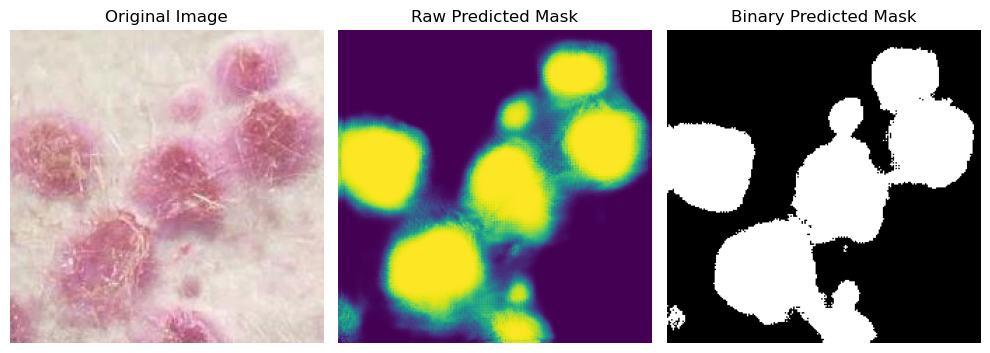

In [24]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Load a single image function
def load_single_image(image_path, img_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, img_size)
   # image = image / 255.0  # Normalize to [0, 1] if required
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict mask for a single image
def predict_mask(model, image_path):
    # Load and preprocess the image
    image_input = load_single_image(image_path)

    # Predict the mask
    predicted_mask_raw = model.predict(image_input)

    # Apply threshold to get binary mask
    threshold = 0.5  # Adjust if necessary
    predicted_mask_binary = (predicted_mask_raw[0] > threshold).astype(np.uint8)

    return predicted_mask_raw[0], predicted_mask_binary

# Custom Dice coefficient
def DiceMetric():
    def dice_coef(y_true, y_pred):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)
    return dice_coef

# Custom IOU Metric
def IoUMetric():
    def iou_coef(y_true, y_pred):
        intersection = tf.keras.backend.sum(y_true * y_pred)
        union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
        return (intersection + 1e-6) / (union + 1e-6)
    return iou_coef

# Load the saved U-Net model with custom_objects for dice_coef and iou_coef
model_path = "best_unet_custom.keras"
unet_model = load_model(model_path, custom_objects={'dice_coef': DiceMetric(), 'iou_coef': IoUMetric()})

# Predict on a single image
image_path = 'mkp_058.jpg'  # Define your image path here
predicted_mask_raw, predicted_mask_binary = predict_mask(unet_model, image_path)

# Visualize the results
def visualize_single_prediction(original_image_path, predicted_mask_raw, predicted_mask_binary):
    # Load the original image for visualization
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask_raw,)
    plt.title("Raw Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask_binary, cmap='gray')
    plt.title("Binary Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the predictions
visualize_single_prediction(image_path, predicted_mask_raw, predicted_mask_binary)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
Number of lesions detected: 9
Symptom Score: 38.83
Image Score: 12.15
Final Severity Score: 25.49
Severity Level: Moderate


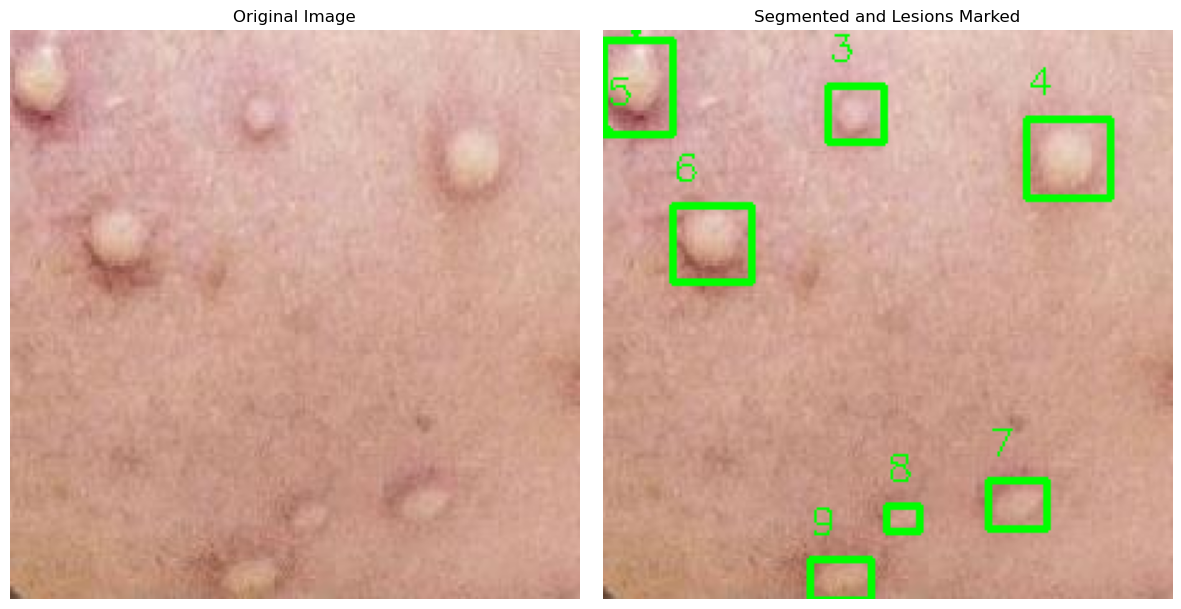

In [27]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Register custom metrics
@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)

@tf.keras.utils.register_keras_serializable()
def iou_coef(y_true, y_pred):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

# Load pre-trained U-Net model
custom_objects = {"dice_coef": dice_coef, "iou_coef": iou_coef}
unet_model = load_model('best_unet_custom.keras', custom_objects=custom_objects)

# Symptom weights and thresholds based on WHO guideline
symptom_weights = {
    'Rectal Pain': 10,
    'Sore Throat': 5,
    'Penile Oedema': 8,
    'Oral Lesions': 12,
    'Solitary Lesion': 7,
    'Swollen Tonsils': 6,
    'HIV Infection': 15,
    'Sexually Transmitted Infection': 10,
    'Systemic Illness_Fever': 10,
    'Systemic Illness_Muscle Aches and Pain': 8,
    'Systemic Illness_Swollen Lymph Nodes': 12,
    'Systemic Illness_n/a': 0
}

T1, T2, T3 = 25, 50, 75  # Severity thresholds
alpha, beta = 0.6, 0.4   # Lesion weight factors
gamma, delta = 0.5, 0.5  # Final score weights
N_max, A_max = 50, 100000

# Function to calculate symptom severity score
def calculate_symptom_score(symptoms, symptom_weights):
    S_symptoms = sum(int(symptoms[symptom]) * symptom_weights[symptom] for symptom in symptoms)
    return (S_symptoms / sum(symptom_weights.values())) * 100

# Function to calculate lesion size
def calculate_lesion_size(predicted_mask, threshold=0.5):
    predicted_mask = np.clip(predicted_mask, 0, 1)
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    num_labels, labels_im = cv2.connectedComponents(binary_mask)
    lesion_sizes = [np.sum(labels_im == label) for label in range(1, num_labels)]
    total_lesion_area = np.sum(lesion_sizes)
    return total_lesion_area, num_labels - 1, lesion_sizes, labels_im

# Function to calculate normalized image-based severity score
def calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta):
    num_lesions_norm = min(num_lesions / N_max, 1.0)
    lesion_area_norm = min(total_lesion_area / A_max, 1.0)
    S_image = 100 * (alpha * num_lesions_norm + beta * lesion_area_norm)
    return S_image

# Function to calculate final normalized severity score
def calculate_final_score(S_symptoms, S_image, gamma, delta):
    S_final = gamma * S_symptoms + delta * S_image
    return min(S_final, 100)

# Function to determine severity level
def determine_severity_level(S_final, T1, T2, T3):
    if S_final < T1:
        return "Mild"
    elif T1 <= S_final < T2:
        return "Moderate"
    elif T2 <= S_final < T3:
        return "Severe"
    else:
        return "Serious"

def process_patient_data(image, symptoms, unet_model):
    predicted_mask = unet_model.predict(np.expand_dims(image, axis=0))[0]
    total_lesion_area, num_lesions, lesion_sizes, labels_im = calculate_lesion_size(predicted_mask)
    S_symptoms = calculate_symptom_score(symptoms, symptom_weights)
    S_image = calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta)
    S_final = calculate_final_score(S_symptoms, S_image, gamma, delta)
    severity_level = determine_severity_level(S_final, T1, T2, T3)
    return S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions, labels_im

# Example patient data
symptoms = {
    'Rectal Pain': True,
    'Sore Throat': False,
    'Penile Oedema': False,
    'Oral Lesions': True,
    'Solitary Lesion': False,
    'Swollen Tonsils': False,
    'HIV Infection': False,
    'Sexually Transmitted Infection': False,
    'Systemic Illness_Fever': True,
    'Systemic Illness_Muscle Aches and Pain': True,
    'Systemic Illness_Swollen Lymph Nodes': False,
    'Systemic Illness_n/a': False
}

# Example image
image = cv2.imread('mkp_046.jpg')
image = cv2.resize(image, (224, 224))

# Process patient data
S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions, labels_im = process_patient_data(image, symptoms, unet_model)

# Threshold the predicted mask
binary_mask = (predicted_mask > 0.5).astype(np.uint8)

# Find connected components
num_labels, labels = cv2.connectedComponents(binary_mask)

# Visualization
overlay_image = image.copy()

for label in range(1, num_labels):  # Skip label 0 (background)
    mask = (labels == label).astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(overlay_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(overlay_image, f'{label}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

print(f"Number of lesions detected: {num_lesions}")
print(f"Symptom Score: {S_symptoms:.2f}")
print(f"Image Score: {S_image:.2f}")
print(f"Final Severity Score: {S_final:.2f}")
print(f"Severity Level: {severity_level}")

# Display
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Segmented and Lesions Marked")
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


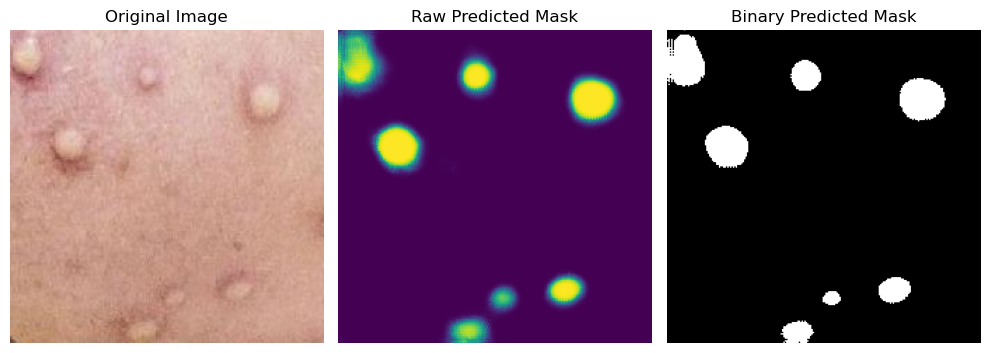

In [30]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Load a single image function
def load_single_image(image_path, img_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, img_size)
   # image = image / 255.0  # Normalize to [0, 1] if required
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict mask for a single image
def predict_mask(model, image_path):
    # Load and preprocess the image
    image_input = load_single_image(image_path)

    # Predict the mask
    predicted_mask_raw = model.predict(image_input)

    # Apply threshold to get binary mask
    threshold = 0.5  # Adjust if necessary
    predicted_mask_binary = (predicted_mask_raw[0] > threshold).astype(np.uint8)

    return predicted_mask_raw[0], predicted_mask_binary

# Custom Dice coefficient
def DiceMetric():
    def dice_coef(y_true, y_pred):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)
    return dice_coef

# Custom IOU Metric
def IoUMetric():
    def iou_coef(y_true, y_pred):
        intersection = tf.keras.backend.sum(y_true * y_pred)
        union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
        return (intersection + 1e-6) / (union + 1e-6)
    return iou_coef

# Load the saved U-Net model with custom_objects for dice_coef and iou_coef
model_path = "best_unet_custom.keras"
unet_model = load_model(model_path, custom_objects={'dice_coef': DiceMetric(), 'iou_coef': IoUMetric()})

# Predict on a single image
image_path = 'mkp_046.jpg'  # Define your image path here
predicted_mask_raw, predicted_mask_binary = predict_mask(unet_model, image_path)

# Visualize the results
def visualize_single_prediction(original_image_path, predicted_mask_raw, predicted_mask_binary):
    # Load the original image for visualization
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask_raw,)
    plt.title("Raw Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask_binary, cmap='gray')
    plt.title("Binary Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the predictions
visualize_single_prediction(image_path, predicted_mask_raw, predicted_mask_binary)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


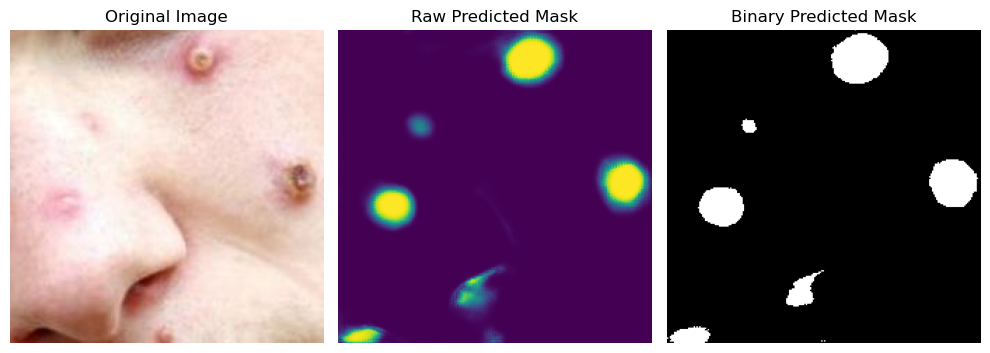

In [39]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Load a single image function
def load_single_image(image_path, img_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, img_size)
   # image = image / 255.0  # Normalize to [0, 1] if required
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict mask for a single image
def predict_mask(model, image_path):
    # Load and preprocess the image
    image_input = load_single_image(image_path)

    # Predict the mask
    predicted_mask_raw = model.predict(image_input)

    # Apply threshold to get binary mask
    threshold = 0.3  # Adjust if necessary
    predicted_mask_binary = (predicted_mask_raw[0] > threshold).astype(np.uint8)

    return predicted_mask_raw[0], predicted_mask_binary

# Custom Dice coefficient
def DiceMetric():
    def dice_coef(y_true, y_pred):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)
    return dice_coef

# Custom IOU Metric
def IoUMetric():
    def iou_coef(y_true, y_pred):
        intersection = tf.keras.backend.sum(y_true * y_pred)
        union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
        return (intersection + 1e-6) / (union + 1e-6)
    return iou_coef

# Load the saved U-Net model with custom_objects for dice_coef and iou_coef
model_path = "best_unet_custom.keras"
unet_model = load_model(model_path, custom_objects={'dice_coef': DiceMetric(), 'iou_coef': IoUMetric()})

# Predict on a single image
image_path = 'mkp_100.jpg'  # Define your image path here
predicted_mask_raw, predicted_mask_binary = predict_mask(unet_model, image_path)

# Visualize the results
def visualize_single_prediction(original_image_path, predicted_mask_raw, predicted_mask_binary):
    # Load the original image for visualization
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask_raw,)
    plt.title("Raw Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask_binary, cmap='gray')
    plt.title("Binary Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the predictions
visualize_single_prediction(image_path, predicted_mask_raw, predicted_mask_binary)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
Number of lesions detected: 8
Symptom Score: 38.83
Image Score: 10.66
Final Severity Score: 24.75
Severity Level: Mild


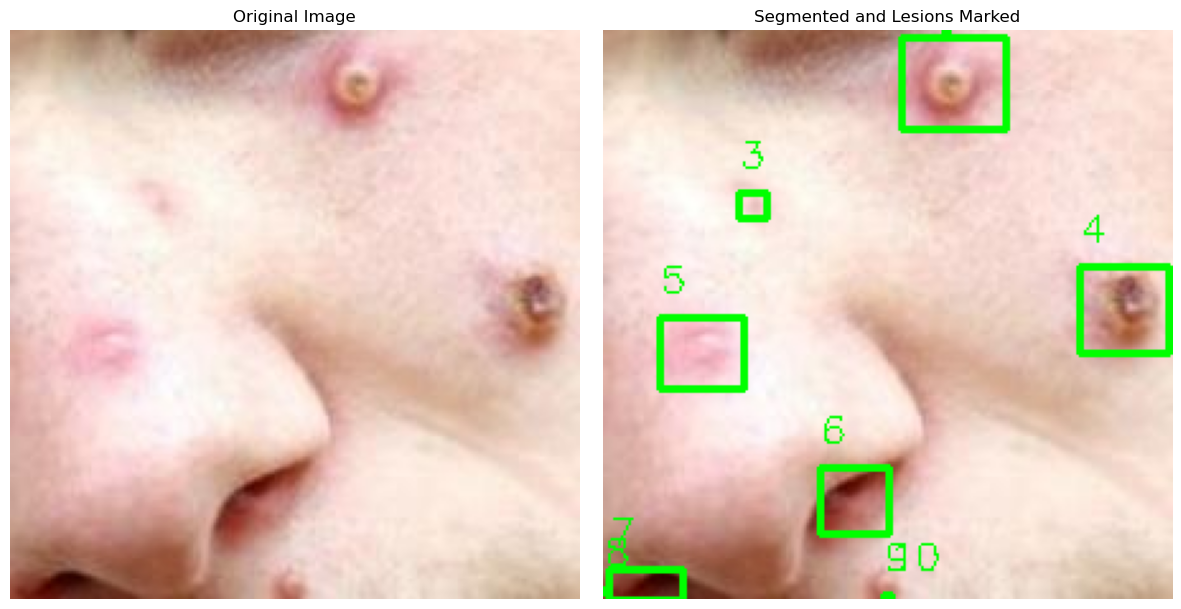

In [41]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Register custom metrics
@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)

@tf.keras.utils.register_keras_serializable()
def iou_coef(y_true, y_pred):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

# Load pre-trained U-Net model
custom_objects = {"dice_coef": dice_coef, "iou_coef": iou_coef}
unet_model = load_model('best_unet_custom.keras', custom_objects=custom_objects)

# Symptom weights and thresholds based on WHO guideline
symptom_weights = {
    'Rectal Pain': 10,
    'Sore Throat': 5,
    'Penile Oedema': 8,
    'Oral Lesions': 12,
    'Solitary Lesion': 7,
    'Swollen Tonsils': 6,
    'HIV Infection': 15,
    'Sexually Transmitted Infection': 10,
    'Systemic Illness_Fever': 10,
    'Systemic Illness_Muscle Aches and Pain': 8,
    'Systemic Illness_Swollen Lymph Nodes': 12,
    'Systemic Illness_n/a': 0
}

T1, T2, T3 = 25, 50, 75  # Severity thresholds
alpha, beta = 0.6, 0.4   # Lesion weight factors
gamma, delta = 0.5, 0.5  # Final score weights
N_max, A_max = 50, 100000

# Function to calculate symptom severity score
def calculate_symptom_score(symptoms, symptom_weights):
    S_symptoms = sum(int(symptoms[symptom]) * symptom_weights[symptom] for symptom in symptoms)
    return (S_symptoms / sum(symptom_weights.values())) * 100

# Function to calculate lesion size
def calculate_lesion_size(predicted_mask, threshold=0.5):
    predicted_mask = np.clip(predicted_mask, 0, 1)
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    num_labels, labels_im = cv2.connectedComponents(binary_mask)
    lesion_sizes = [np.sum(labels_im == label) for label in range(1, num_labels)]
    total_lesion_area = np.sum(lesion_sizes)
    return total_lesion_area, num_labels - 1, lesion_sizes, labels_im

# Function to calculate normalized image-based severity score
def calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta):
    num_lesions_norm = min(num_lesions / N_max, 1.0)
    lesion_area_norm = min(total_lesion_area / A_max, 1.0)
    S_image = 100 * (alpha * num_lesions_norm + beta * lesion_area_norm)
    return S_image

# Function to calculate final normalized severity score
def calculate_final_score(S_symptoms, S_image, gamma, delta):
    S_final = gamma * S_symptoms + delta * S_image
    return min(S_final, 100)

# Function to determine severity level
def determine_severity_level(S_final, T1, T2, T3):
    if S_final < T1:
        return "Mild"
    elif T1 <= S_final < T2:
        return "Moderate"
    elif T2 <= S_final < T3:
        return "Severe"
    else:
        return "Serious"

def process_patient_data(image, symptoms, unet_model):
    predicted_mask = unet_model.predict(np.expand_dims(image, axis=0))[0]
    total_lesion_area, num_lesions, lesion_sizes, labels_im = calculate_lesion_size(predicted_mask)
    S_symptoms = calculate_symptom_score(symptoms, symptom_weights)
    S_image = calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta)
    S_final = calculate_final_score(S_symptoms, S_image, gamma, delta)
    severity_level = determine_severity_level(S_final, T1, T2, T3)
    return S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions, labels_im

# Example patient data
symptoms = {
    'Rectal Pain': True,
    'Sore Throat': False,
    'Penile Oedema': False,
    'Oral Lesions': True,
    'Solitary Lesion': False,
    'Swollen Tonsils': False,
    'HIV Infection': False,
    'Sexually Transmitted Infection': False,
    'Systemic Illness_Fever': True,
    'Systemic Illness_Muscle Aches and Pain': True,
    'Systemic Illness_Swollen Lymph Nodes': False,
    'Systemic Illness_n/a': False
}

# Example image
image = cv2.imread('mkp_100.jpg')
image = cv2.resize(image, (224, 224))

# Process patient data
S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions, labels_im = process_patient_data(image, symptoms, unet_model)

# Threshold the predicted mask
binary_mask = (predicted_mask > 0.3).astype(np.uint8)

# Find connected components
num_labels, labels = cv2.connectedComponents(binary_mask)

# Visualization
overlay_image = image.copy()

for label in range(1, num_labels):  # Skip label 0 (background)
    mask = (labels == label).astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(overlay_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(overlay_image, f'{label}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

print(f"Number of lesions detected: {num_lesions}")
print(f"Symptom Score: {S_symptoms:.2f}")
print(f"Image Score: {S_image:.2f}")
print(f"Final Severity Score: {S_final:.2f}")
print(f"Severity Level: {severity_level}")

# Display
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Segmented and Lesions Marked")
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


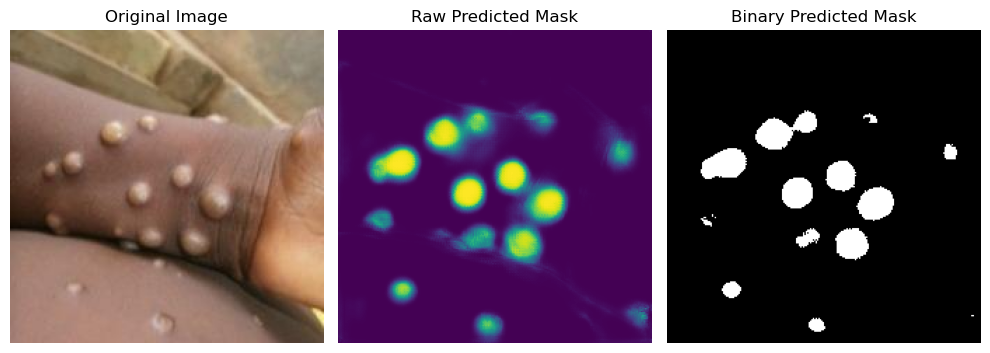

In [33]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Load a single image function
def load_single_image(image_path, img_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, img_size)
   # image = image / 255.0  # Normalize to [0, 1] if required
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict mask for a single image
def predict_mask(model, image_path):
    # Load and preprocess the image
    image_input = load_single_image(image_path)

    # Predict the mask
    predicted_mask_raw = model.predict(image_input)

    # Apply threshold to get binary mask
    threshold = 0.5  # Adjust if necessary
    predicted_mask_binary = (predicted_mask_raw[0] > threshold).astype(np.uint8)

    return predicted_mask_raw[0], predicted_mask_binary

# Custom Dice coefficient
def DiceMetric():
    def dice_coef(y_true, y_pred):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)
    return dice_coef

# Custom IOU Metric
def IoUMetric():
    def iou_coef(y_true, y_pred):
        intersection = tf.keras.backend.sum(y_true * y_pred)
        union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
        return (intersection + 1e-6) / (union + 1e-6)
    return iou_coef

# Load the saved U-Net model with custom_objects for dice_coef and iou_coef
model_path = "best_unet_custom.keras"
unet_model = load_model(model_path, custom_objects={'dice_coef': DiceMetric(), 'iou_coef': IoUMetric()})

# Predict on a single image
image_path = 'mkp_047.jpg'  # Define your image path here
predicted_mask_raw, predicted_mask_binary = predict_mask(unet_model, image_path)

# Visualize the results
def visualize_single_prediction(original_image_path, predicted_mask_raw, predicted_mask_binary):
    # Load the original image for visualization
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask_raw,)
    plt.title("Raw Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask_binary, cmap='gray')
    plt.title("Binary Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the predictions
visualize_single_prediction(image_path, predicted_mask_raw, predicted_mask_binary)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
Number of lesions detected: 8
Symptom Score: 38.83
Image Score: 10.66
Final Severity Score: 30.38
Severity Level: Moderate


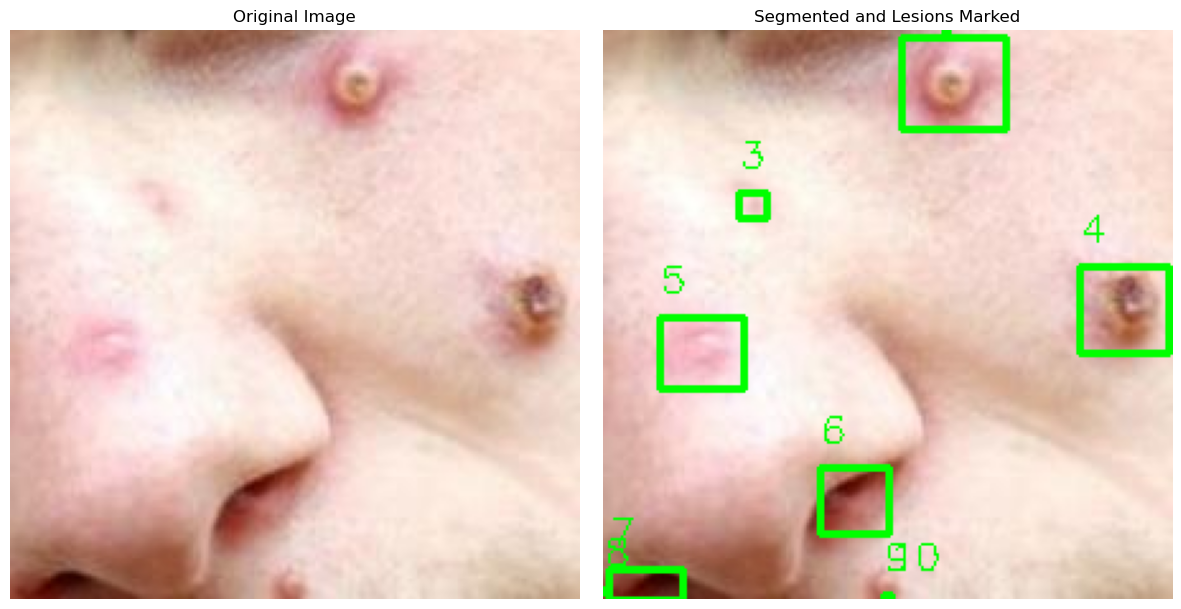

In [43]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Register custom metrics
@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)

@tf.keras.utils.register_keras_serializable()
def iou_coef(y_true, y_pred):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

# Load pre-trained U-Net model
custom_objects = {"dice_coef": dice_coef, "iou_coef": iou_coef}
unet_model = load_model('best_unet_custom.keras', custom_objects=custom_objects)

# Symptom weights and thresholds based on WHO guideline
symptom_weights = {
    'Rectal Pain': 10,
    'Sore Throat': 5,
    'Penile Oedema': 8,
    'Oral Lesions': 12,
    'Solitary Lesion': 7,
    'Swollen Tonsils': 6,
    'HIV Infection': 15,
    'Sexually Transmitted Infection': 10,
    'Systemic Illness_Fever': 10,
    'Systemic Illness_Muscle Aches and Pain': 8,
    'Systemic Illness_Swollen Lymph Nodes': 12,
    'Systemic Illness_n/a': 0
}

T1, T2, T3 = 25, 50, 75  # Severity thresholds
alpha, beta = 0.6, 0.4   # Lesion weight factors
gamma, delta = 0.7, 0.3  # Final score weights
N_max, A_max = 50, 100000

# Function to calculate symptom severity score
def calculate_symptom_score(symptoms, symptom_weights):
    S_symptoms = sum(int(symptoms[symptom]) * symptom_weights[symptom] for symptom in symptoms)
    return (S_symptoms / sum(symptom_weights.values())) * 100

# Function to calculate lesion size
def calculate_lesion_size(predicted_mask, threshold=0.5):
    predicted_mask = np.clip(predicted_mask, 0, 1)
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    num_labels, labels_im = cv2.connectedComponents(binary_mask)
    lesion_sizes = [np.sum(labels_im == label) for label in range(1, num_labels)]
    total_lesion_area = np.sum(lesion_sizes)
    return total_lesion_area, num_labels - 1, lesion_sizes, labels_im

# Function to calculate normalized image-based severity score
def calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta):
    num_lesions_norm = min(num_lesions / N_max, 1.0)
    lesion_area_norm = min(total_lesion_area / A_max, 1.0)
    S_image = 100 * (alpha * num_lesions_norm + beta * lesion_area_norm)
    return S_image

# Function to calculate final normalized severity score
def calculate_final_score(S_symptoms, S_image, gamma, delta):
    S_final = gamma * S_symptoms + delta * S_image
    return min(S_final, 100)

# Function to determine severity level
def determine_severity_level(S_final, T1, T2, T3):
    if S_final < T1:
        return "Mild"
    elif T1 <= S_final < T2:
        return "Moderate"
    elif T2 <= S_final < T3:
        return "Severe"
    else:
        return "Serious"

def process_patient_data(image, symptoms, unet_model):
    predicted_mask = unet_model.predict(np.expand_dims(image, axis=0))[0]
    total_lesion_area, num_lesions, lesion_sizes, labels_im = calculate_lesion_size(predicted_mask)
    S_symptoms = calculate_symptom_score(symptoms, symptom_weights)
    S_image = calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta)
    S_final = calculate_final_score(S_symptoms, S_image, gamma, delta)
    severity_level = determine_severity_level(S_final, T1, T2, T3)
    return S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions, labels_im

# Example patient data
symptoms = {
    'Rectal Pain': True,
    'Sore Throat': False,
    'Penile Oedema': False,
    'Oral Lesions': True,
    'Solitary Lesion': False,
    'Swollen Tonsils': False,
    'HIV Infection': False,
    'Sexually Transmitted Infection': False,
    'Systemic Illness_Fever': True,
    'Systemic Illness_Muscle Aches and Pain': True,
    'Systemic Illness_Swollen Lymph Nodes': False,
    'Systemic Illness_n/a': False
}

# Example image
image = cv2.imread('mkp_100.jpg')
image = cv2.resize(image, (224, 224))

# Process patient data
S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions, labels_im = process_patient_data(image, symptoms, unet_model)

# Threshold the predicted mask
binary_mask = (predicted_mask > 0.3).astype(np.uint8)

# Find connected components
num_labels, labels = cv2.connectedComponents(binary_mask)

# Visualization
overlay_image = image.copy()

for label in range(1, num_labels):  # Skip label 0 (background)
    mask = (labels == label).astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(overlay_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(overlay_image, f'{label}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

print(f"Number of lesions detected: {num_lesions}")
print(f"Symptom Score: {S_symptoms:.2f}")
print(f"Image Score: {S_image:.2f}")
print(f"Final Severity Score: {S_final:.2f}")
print(f"Severity Level: {severity_level}")

# Display
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Segmented and Lesions Marked")
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


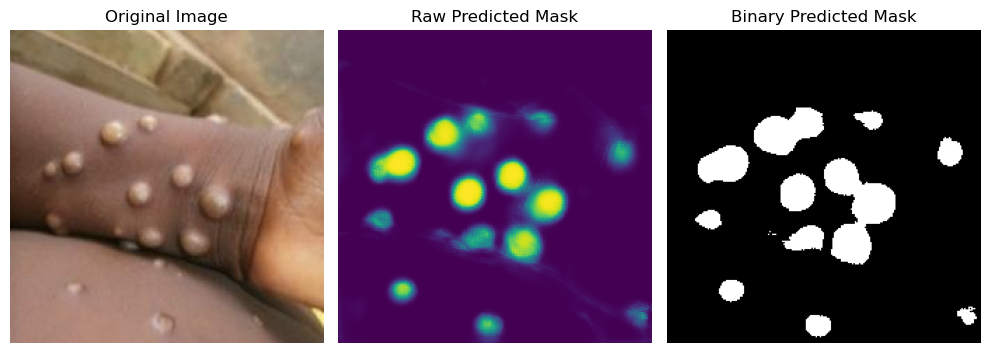

In [48]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Load a single image function
def load_single_image(image_path, img_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, img_size)
   # image = image / 255.0  # Normalize to [0, 1] if required
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict mask for a single image
def predict_mask(model, image_path):
    # Load and preprocess the image
    image_input = load_single_image(image_path)

    # Predict the mask
    predicted_mask_raw = model.predict(image_input)

    # Apply threshold to get binary mask
    threshold = 0.2  # Adjust if necessary
    predicted_mask_binary = (predicted_mask_raw[0] > threshold).astype(np.uint8)

    return predicted_mask_raw[0], predicted_mask_binary

# Custom Dice coefficient
def DiceMetric():
    def dice_coef(y_true, y_pred):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)
    return dice_coef

# Custom IOU Metric
def IoUMetric():
    def iou_coef(y_true, y_pred):
        intersection = tf.keras.backend.sum(y_true * y_pred)
        union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
        return (intersection + 1e-6) / (union + 1e-6)
    return iou_coef

# Load the saved U-Net model with custom_objects for dice_coef and iou_coef
model_path = "best_unet_custom.keras"
unet_model = load_model(model_path, custom_objects={'dice_coef': DiceMetric(), 'iou_coef': IoUMetric()})

# Predict on a single image
image_path = 'mkp_047.jpg'  # Define your image path here
predicted_mask_raw, predicted_mask_binary = predict_mask(unet_model, image_path)

# Visualize the results
def visualize_single_prediction(original_image_path, predicted_mask_raw, predicted_mask_binary):
    # Load the original image for visualization
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask_raw,)
    plt.title("Raw Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask_binary, cmap='gray')
    plt.title("Binary Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the predictions
visualize_single_prediction(image_path, predicted_mask_raw, predicted_mask_binary)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
Number of lesions detected: 15
Symptom Score: 38.83
Image Score: 19.33
Final Severity Score: 32.98
Severity Level: Moderate


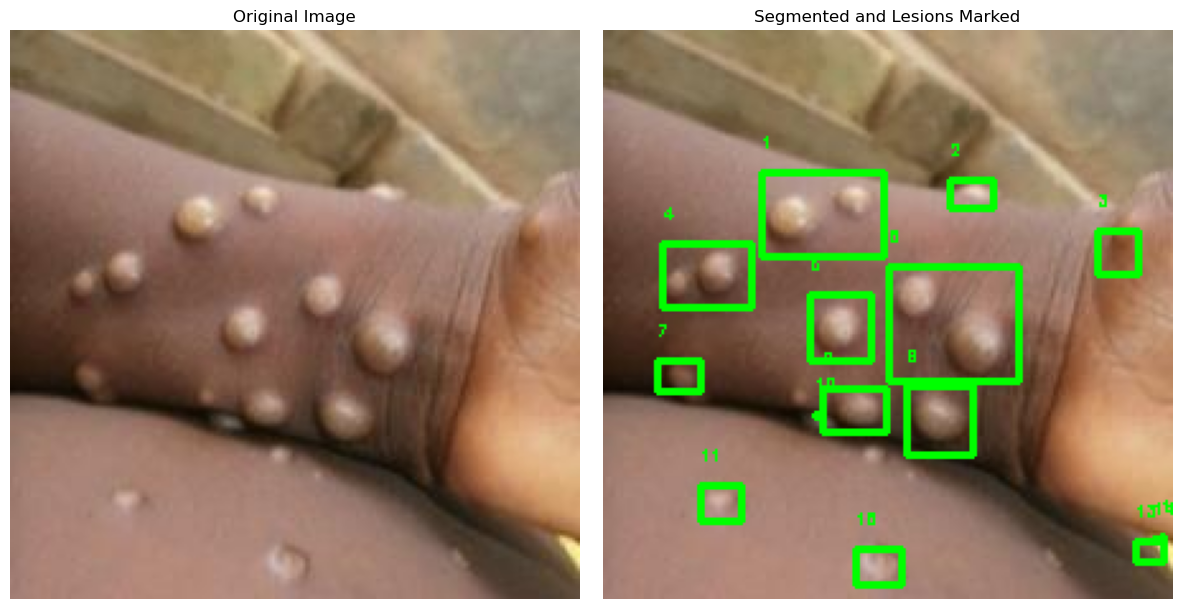

In [47]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Register custom metrics
@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)

@tf.keras.utils.register_keras_serializable()
def iou_coef(y_true, y_pred):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

# Load pre-trained U-Net model
custom_objects = {"dice_coef": dice_coef, "iou_coef": iou_coef}
unet_model = load_model('best_unet_custom.keras', custom_objects=custom_objects)

# Symptom weights and thresholds based on WHO guideline
symptom_weights = {
    'Rectal Pain': 10,
    'Sore Throat': 5,
    'Penile Oedema': 8,
    'Oral Lesions': 12,
    'Solitary Lesion': 7,
    'Swollen Tonsils': 6,
    'HIV Infection': 15,
    'Sexually Transmitted Infection': 10,
    'Systemic Illness_Fever': 10,
    'Systemic Illness_Muscle Aches and Pain': 8,
    'Systemic Illness_Swollen Lymph Nodes': 12,
    'Systemic Illness_n/a': 0
}

T1, T2, T3 = 25, 50, 75  # Severity thresholds
alpha, beta = 0.6, 0.4   # Lesion weight factors
gamma, delta = 0.7, 0.3  # Final score weights
N_max, A_max = 50, 100000

# Function to calculate symptom severity score
def calculate_symptom_score(symptoms, symptom_weights):
    S_symptoms = sum(int(symptoms[symptom]) * symptom_weights[symptom] for symptom in symptoms)
    return (S_symptoms / sum(symptom_weights.values())) * 100

# Function to calculate lesion size
def calculate_lesion_size(predicted_mask, threshold=0.5):
    predicted_mask = np.clip(predicted_mask, 0, 1)
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    num_labels, labels_im = cv2.connectedComponents(binary_mask)
    lesion_sizes = [np.sum(labels_im == label) for label in range(1, num_labels)]
    total_lesion_area = np.sum(lesion_sizes)
    return total_lesion_area, num_labels - 1, lesion_sizes, labels_im

# Function to calculate normalized image-based severity score
def calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta):
    num_lesions_norm = min(num_lesions / N_max, 1.0)
    lesion_area_norm = min(total_lesion_area / A_max, 1.0)
    S_image = 100 * (alpha * num_lesions_norm + beta * lesion_area_norm)
    return S_image

# Function to calculate final normalized severity score
def calculate_final_score(S_symptoms, S_image, gamma, delta):
    S_final = gamma * S_symptoms + delta * S_image
    return min(S_final, 100)

# Function to determine severity level
def determine_severity_level(S_final, T1, T2, T3):
    if S_final < T1:
        return "Mild"
    elif T1 <= S_final < T2:
        return "Moderate"
    elif T2 <= S_final < T3:
        return "Severe"
    else:
        return "Serious"

def process_patient_data(image, symptoms, unet_model):
    predicted_mask = unet_model.predict(np.expand_dims(image, axis=0))[0]
    total_lesion_area, num_lesions, lesion_sizes, labels_im = calculate_lesion_size(predicted_mask)
    S_symptoms = calculate_symptom_score(symptoms, symptom_weights)
    S_image = calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta)
    S_final = calculate_final_score(S_symptoms, S_image, gamma, delta)
    severity_level = determine_severity_level(S_final, T1, T2, T3)
    return S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions, labels_im

# Example patient data
symptoms = {
    'Rectal Pain': True,
    'Sore Throat': False,
    'Penile Oedema': False,
    'Oral Lesions': True,
    'Solitary Lesion': False,
    'Swollen Tonsils': False,
    'HIV Infection': False,
    'Sexually Transmitted Infection': False,
    'Systemic Illness_Fever': True,
    'Systemic Illness_Muscle Aches and Pain': True,
    'Systemic Illness_Swollen Lymph Nodes': False,
    'Systemic Illness_n/a': False
}

# Example image
image = cv2.imread('mkp_047.jpg')
image = cv2.resize(image, (224, 224))

# Process patient data
S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions, labels_im = process_patient_data(image, symptoms, unet_model)

# Threshold the predicted mask
binary_mask = (predicted_mask > 0.3).astype(np.uint8)

# Find connected components
num_labels, labels = cv2.connectedComponents(binary_mask)

# Visualization
overlay_image = image.copy()

for label in range(1, num_labels):  # Skip label 0 (background)
    mask = (labels == label).astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(overlay_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(overlay_image, f'{label}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (0, 255, 0), 1)

print(f"Number of lesions detected: {num_lesions}")
print(f"Symptom Score: {S_symptoms:.2f}")
print(f"Image Score: {S_image:.2f}")
print(f"Final Severity Score: {S_final:.2f}")
print(f"Severity Level: {severity_level}")

# Display
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Segmented and Lesions Marked")
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
Number of lesions detected: 8
Symptom Score: 38.83
Image Score: 10.66
Final Severity Score: 24.75
Severity Level: Moderate


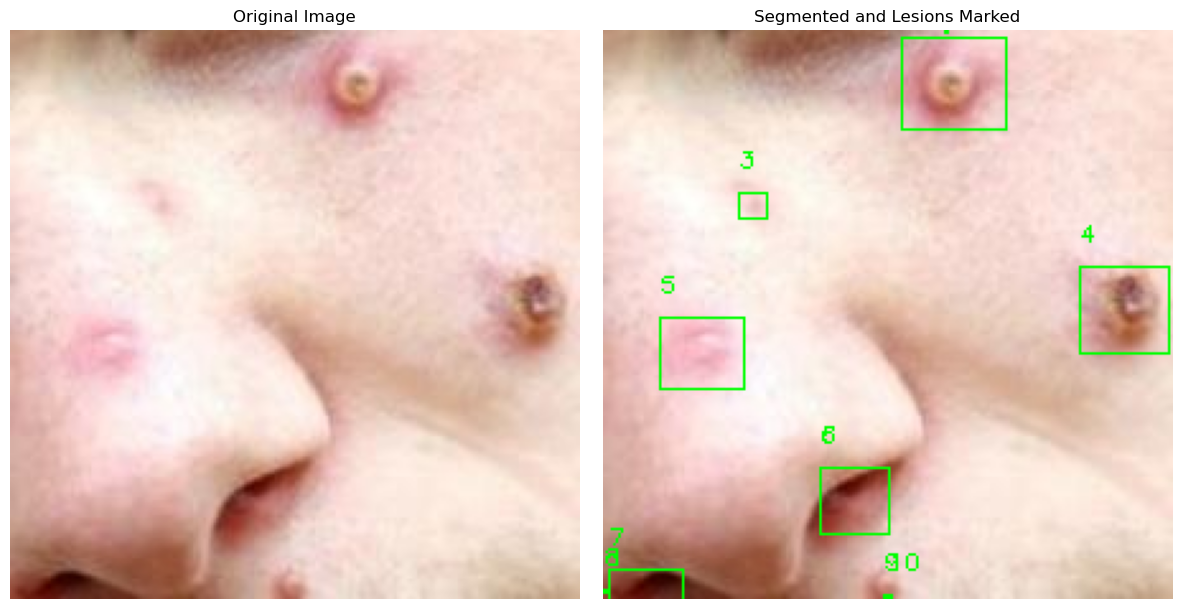

In [56]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Register custom metrics
@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)

@tf.keras.utils.register_keras_serializable()
def iou_coef(y_true, y_pred):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

# Load pre-trained U-Net model
custom_objects = {"dice_coef": dice_coef, "iou_coef": iou_coef}
unet_model = load_model('best_unet_custom.keras', custom_objects=custom_objects)

# Symptom weights and thresholds based on WHO guideline
symptom_weights = {
    'Rectal Pain': 10,
    'Sore Throat': 5,
    'Penile Oedema': 8,
    'Oral Lesions': 12,
    'Solitary Lesion': 7,
    'Swollen Tonsils': 6,
    'HIV Infection': 15,
    'Sexually Transmitted Infection': 10,
    'Systemic Illness_Fever': 10,
    'Systemic Illness_Muscle Aches and Pain': 8,
    'Systemic Illness_Swollen Lymph Nodes': 12,
    'Systemic Illness_n/a': 0
}

T1, T2, T3 = 20, 50, 75  # Severity thresholds
alpha, beta = 0.6, 0.4   # Lesion weight factors
gamma, delta = 0.5, 0.5  # Final score weights
N_max, A_max = 50, 100000

# Function to calculate symptom severity score
def calculate_symptom_score(symptoms, symptom_weights):
    S_symptoms = sum(int(symptoms[symptom]) * symptom_weights[symptom] for symptom in symptoms)
    return (S_symptoms / sum(symptom_weights.values())) * 100

# Function to calculate lesion size
def calculate_lesion_size(predicted_mask, threshold=0.5):
    predicted_mask = np.clip(predicted_mask, 0, 1)
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    num_labels, labels_im = cv2.connectedComponents(binary_mask)
    lesion_sizes = [np.sum(labels_im == label) for label in range(1, num_labels)]
    total_lesion_area = np.sum(lesion_sizes)
    return total_lesion_area, num_labels - 1, lesion_sizes, labels_im

# Function to calculate normalized image-based severity score
def calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta):
    num_lesions_norm = min(num_lesions / N_max, 1.0)
    lesion_area_norm = min(total_lesion_area / A_max, 1.0)
    S_image = 100 * (alpha * num_lesions_norm + beta * lesion_area_norm)
    return S_image

# Function to calculate final normalized severity score
def calculate_final_score(S_symptoms, S_image, gamma, delta):
    S_final = gamma * S_symptoms + delta * S_image
    return min(S_final, 100)

# Function to determine severity level
def determine_severity_level(S_final, T1, T2, T3):
    if S_final < T1:
        return "Mild"
    elif T1 <= S_final < T2:
        return "Moderate"
    elif T2 <= S_final < T3:
        return "Severe"
    else:
        return "Serious"

def process_patient_data(image, symptoms, unet_model):
    predicted_mask = unet_model.predict(np.expand_dims(image, axis=0))[0]
    total_lesion_area, num_lesions, lesion_sizes, labels_im = calculate_lesion_size(predicted_mask)
    S_symptoms = calculate_symptom_score(symptoms, symptom_weights)
    S_image = calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta)
    S_final = calculate_final_score(S_symptoms, S_image, gamma, delta)
    severity_level = determine_severity_level(S_final, T1, T2, T3)
    return S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions, labels_im

# Example patient data
symptoms = {
    'Rectal Pain': True,
    'Sore Throat': False,
    'Penile Oedema': False,
    'Oral Lesions': True,
    'Solitary Lesion': False,
    'Swollen Tonsils': False,
    'HIV Infection': False,
    'Sexually Transmitted Infection': False,
    'Systemic Illness_Fever': True,
    'Systemic Illness_Muscle Aches and Pain': True,
    'Systemic Illness_Swollen Lymph Nodes': False,
    'Systemic Illness_n/a': False
}

# Example image
image = cv2.imread('mkp_100.jpg')
image = cv2.resize(image, (224, 224))

# Process patient data
S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions, labels_im = process_patient_data(image, symptoms, unet_model)

# Threshold the predicted mask
binary_mask = (predicted_mask > 0.3).astype(np.uint8)

# Find connected components
num_labels, labels = cv2.connectedComponents(binary_mask)

# Visualization
overlay_image = image.copy()

for label in range(1, num_labels):  # Skip label 0 (background)
    mask = (labels == label).astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(overlay_image, (x, y), (x+w, y+h), (0, 255, 0), 1)
        cv2.putText(overlay_image, f'{label}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)

print(f"Number of lesions detected: {num_lesions}")
print(f"Symptom Score: {S_symptoms:.2f}")
print(f"Image Score: {S_image:.2f}")
print(f"Final Severity Score: {S_final:.2f}")
print(f"Severity Level: {severity_level}")

# Display
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Segmented and Lesions Marked")
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
Number of lesions detected: 9
Symptom Score: 38.83
Image Score: 12.15
Final Severity Score: 25.49
Severity Level: Moderate


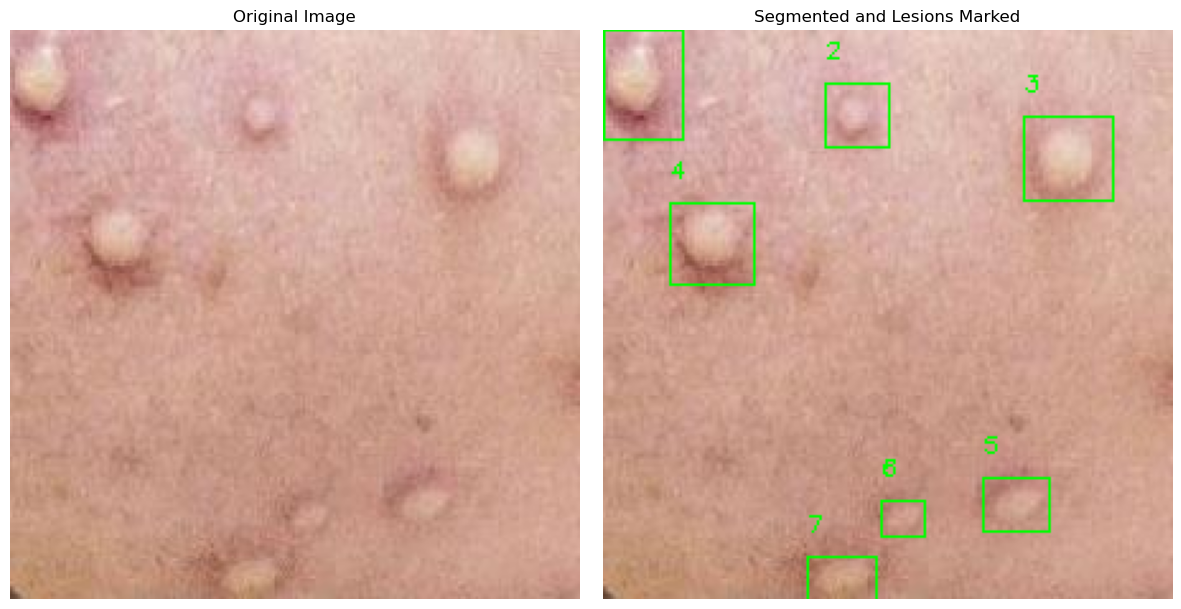

In [60]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Register custom metrics
@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)

@tf.keras.utils.register_keras_serializable()
def iou_coef(y_true, y_pred):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

# Load pre-trained U-Net model
custom_objects = {"dice_coef": dice_coef, "iou_coef": iou_coef}
unet_model = load_model('best_unet_custom.keras', custom_objects=custom_objects)

# Symptom weights and thresholds based on WHO guideline
symptom_weights = {
    'Rectal Pain': 10,
    'Sore Throat': 5,
    'Penile Oedema': 8,
    'Oral Lesions': 12,
    'Solitary Lesion': 7,
    'Swollen Tonsils': 6,
    'HIV Infection': 15,
    'Sexually Transmitted Infection': 10,
    'Systemic Illness_Fever': 10,
    'Systemic Illness_Muscle Aches and Pain': 8,
    'Systemic Illness_Swollen Lymph Nodes': 12,
    'Systemic Illness_n/a': 0
}

T1, T2, T3 = 20, 50, 75  # Severity thresholds
alpha, beta = 0.6, 0.4   # Lesion weight factors
gamma, delta = 0.5, 0.5  # Final score weights
N_max, A_max = 50, 100000

# Function to calculate symptom severity score
def calculate_symptom_score(symptoms, symptom_weights):
    S_symptoms = sum(int(symptoms[symptom]) * symptom_weights[symptom] for symptom in symptoms)
    return (S_symptoms / sum(symptom_weights.values())) * 100

# Function to calculate lesion size
def calculate_lesion_size(predicted_mask, threshold=0.5):
    predicted_mask = np.clip(predicted_mask, 0, 1)
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    num_labels, labels_im = cv2.connectedComponents(binary_mask)
    lesion_sizes = [np.sum(labels_im == label) for label in range(1, num_labels)]
    total_lesion_area = np.sum(lesion_sizes)
    return total_lesion_area, num_labels - 1, lesion_sizes, labels_im

# Function to calculate normalized image-based severity score
def calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta):
    num_lesions_norm = min(num_lesions / N_max, 1.0)
    lesion_area_norm = min(total_lesion_area / A_max, 1.0)
    S_image = 100 * (alpha * num_lesions_norm + beta * lesion_area_norm)
    return S_image

# Function to calculate final normalized severity score
def calculate_final_score(S_symptoms, S_image, gamma, delta):
    S_final = gamma * S_symptoms + delta * S_image
    return min(S_final, 100)

# Function to determine severity level
def determine_severity_level(S_final, T1, T2, T3):
    if S_final < T1:
        return "Mild"
    elif T1 <= S_final < T2:
        return "Moderate"
    elif T2 <= S_final < T3:
        return "Severe"
    else:
        return "Serious"

def process_patient_data(image, symptoms, unet_model):
    predicted_mask = unet_model.predict(np.expand_dims(image, axis=0))[0]
    total_lesion_area, num_lesions, lesion_sizes, labels_im = calculate_lesion_size(predicted_mask)
    S_symptoms = calculate_symptom_score(symptoms, symptom_weights)
    S_image = calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta)
    S_final = calculate_final_score(S_symptoms, S_image, gamma, delta)
    severity_level = determine_severity_level(S_final, T1, T2, T3)
    return S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions, labels_im

# Example patient data
symptoms = {
    'Rectal Pain': True,
    'Sore Throat': False,
    'Penile Oedema': False,
    'Oral Lesions': True,
    'Solitary Lesion': False,
    'Swollen Tonsils': False,
    'HIV Infection': False,
    'Sexually Transmitted Infection': False,
    'Systemic Illness_Fever': True,
    'Systemic Illness_Muscle Aches and Pain': True,
    'Systemic Illness_Swollen Lymph Nodes': False,
    'Systemic Illness_n/a': False
}

# Example image
image = cv2.imread('mkp_046.jpg')
image = cv2.resize(image, (224, 224))

# Process patient data
S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions, labels_im = process_patient_data(image, symptoms, unet_model)

# Threshold the predicted mask
binary_mask = (predicted_mask > 0.3).astype(np.uint8)

# Find connected components
num_labels, labels = cv2.connectedComponents(binary_mask)

# Visualization
overlay_image = image.copy()

for label in range(1, num_labels):  # Skip label 0 (background)
    mask = (labels == label).astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(overlay_image, (x, y), (x+w, y+h), (0, 255, 0), 1)
        cv2.putText(overlay_image, f'{label}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)

print(f"Number of lesions detected: {num_lesions}")
print(f"Symptom Score: {S_symptoms:.2f}")
print(f"Image Score: {S_image:.2f}")
print(f"Final Severity Score: {S_final:.2f}")
print(f"Severity Level: {severity_level}")

# Display
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Segmented and Lesions Marked")
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


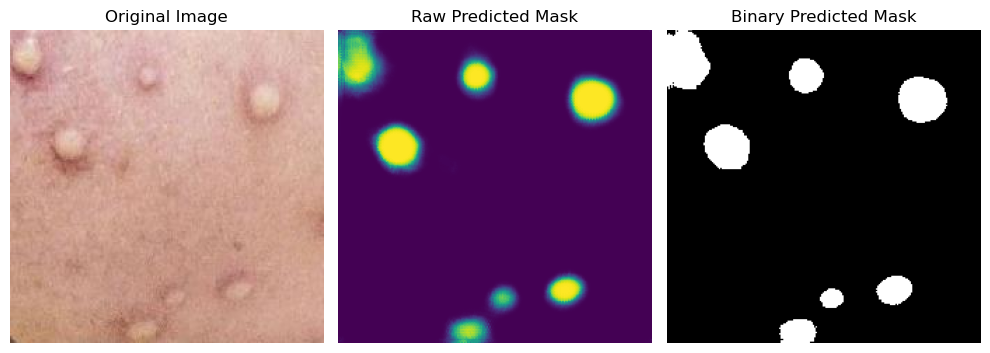

In [58]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Load a single image function
def load_single_image(image_path, img_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, img_size)
   # image = image / 255.0  # Normalize to [0, 1] if required
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict mask for a single image
def predict_mask(model, image_path):
    # Load and preprocess the image
    image_input = load_single_image(image_path)

    # Predict the mask
    predicted_mask_raw = model.predict(image_input)

    # Apply threshold to get binary mask
    threshold = 0.3  # Adjust if necessary
    predicted_mask_binary = (predicted_mask_raw[0] > threshold).astype(np.uint8)

    return predicted_mask_raw[0], predicted_mask_binary

# Custom Dice coefficient
def DiceMetric():
    def dice_coef(y_true, y_pred):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)
    return dice_coef

# Custom IOU Metric
def IoUMetric():
    def iou_coef(y_true, y_pred):
        intersection = tf.keras.backend.sum(y_true * y_pred)
        union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
        return (intersection + 1e-6) / (union + 1e-6)
    return iou_coef

# Load the saved U-Net model with custom_objects for dice_coef and iou_coef
model_path = "best_unet_custom.keras"
unet_model = load_model(model_path, custom_objects={'dice_coef': DiceMetric(), 'iou_coef': IoUMetric()})

# Predict on a single image
image_path = 'mkp_046.jpg'  # Define your image path here
predicted_mask_raw, predicted_mask_binary = predict_mask(unet_model, image_path)

# Visualize the results
def visualize_single_prediction(original_image_path, predicted_mask_raw, predicted_mask_binary):
    # Load the original image for visualization
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask_raw,)
    plt.title("Raw Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask_binary, cmap='gray')
    plt.title("Binary Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the predictions
visualize_single_prediction(image_path, predicted_mask_raw, predicted_mask_binary)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
Number of lesions detected: 8
Symptom Score: 38.83
Image Score: 10.66
Final Severity Score: 24.75
Severity Level: Moderate


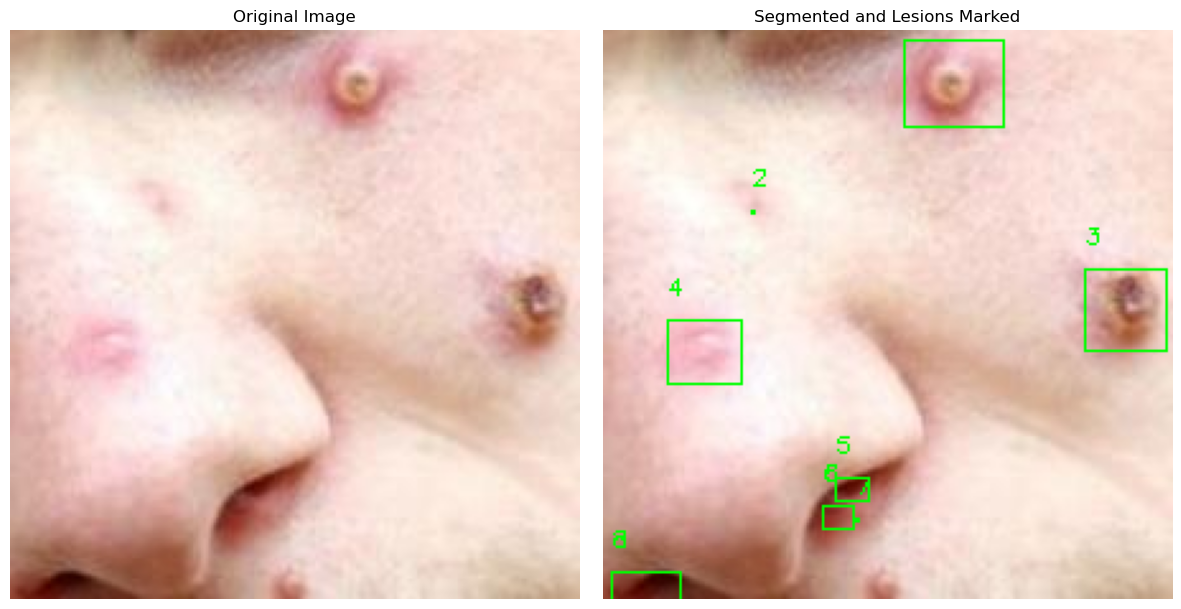

In [69]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Register custom metrics
@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)

@tf.keras.utils.register_keras_serializable()
def iou_coef(y_true, y_pred):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

# Load pre-trained U-Net model
custom_objects = {"dice_coef": dice_coef, "iou_coef": iou_coef}
unet_model = load_model('best_unet_custom.keras', custom_objects=custom_objects)

# Symptom weights and thresholds based on WHO guideline
symptom_weights = {
    'Rectal Pain': 10,
    'Sore Throat': 5,
    'Penile Oedema': 8,
    'Oral Lesions': 12,
    'Solitary Lesion': 7,
    'Swollen Tonsils': 6,
    'HIV Infection': 15,
    'Sexually Transmitted Infection': 10,
    'Systemic Illness_Fever': 10,
    'Systemic Illness_Muscle Aches and Pain': 8,
    'Systemic Illness_Swollen Lymph Nodes': 12,
    'Systemic Illness_n/a': 0
}

T1, T2, T3 = 20, 50, 75  # Severity thresholds
alpha, beta = 0.6, 0.4   # Lesion weight factors
gamma, delta = 0.5, 0.5  # Final score weights
N_max, A_max = 50, 100000

# Function to calculate symptom severity score
def calculate_symptom_score(symptoms, symptom_weights):
    S_symptoms = sum(int(symptoms[symptom]) * symptom_weights[symptom] for symptom in symptoms)
    return (S_symptoms / sum(symptom_weights.values())) * 100

# Function to calculate lesion size
def calculate_lesion_size(predicted_mask, threshold=0.5):
    predicted_mask = np.clip(predicted_mask, 0, 1)
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    num_labels, labels_im = cv2.connectedComponents(binary_mask)
    lesion_sizes = [np.sum(labels_im == label) for label in range(1, num_labels)]
    total_lesion_area = np.sum(lesion_sizes)
    return total_lesion_area, num_labels - 1, lesion_sizes, labels_im

# Function to calculate normalized image-based severity score
def calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta):
    num_lesions_norm = min(num_lesions / N_max, 1.0)
    lesion_area_norm = min(total_lesion_area / A_max, 1.0)
    S_image = 100 * (alpha * num_lesions_norm + beta * lesion_area_norm)
    return S_image

# Function to calculate final normalized severity score
def calculate_final_score(S_symptoms, S_image, gamma, delta):
    S_final = gamma * S_symptoms + delta * S_image
    return min(S_final, 100)

# Function to determine severity level
def determine_severity_level(S_final, T1, T2, T3):
    if S_final < T1:
        return "Mild"
    elif T1 <= S_final < T2:
        return "Moderate"
    elif T2 <= S_final < T3:
        return "Severe"
    else:
        return "Serious"

def process_patient_data(image, symptoms, unet_model):
    predicted_mask = unet_model.predict(np.expand_dims(image, axis=0))[0]
    total_lesion_area, num_lesions, lesion_sizes, labels_im = calculate_lesion_size(predicted_mask)
    S_symptoms = calculate_symptom_score(symptoms, symptom_weights)
    S_image = calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta)
    S_final = calculate_final_score(S_symptoms, S_image, gamma, delta)
    severity_level = determine_severity_level(S_final, T1, T2, T3)
    return S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions, labels_im

# Example patient data
symptoms = {
    'Rectal Pain': True,
    'Sore Throat': False,
    'Penile Oedema': False,
    'Oral Lesions': True,
    'Solitary Lesion': False,
    'Swollen Tonsils': False,
    'HIV Infection': False,
    'Sexually Transmitted Infection': False,
    'Systemic Illness_Fever': True,
    'Systemic Illness_Muscle Aches and Pain': True,
    'Systemic Illness_Swollen Lymph Nodes': False,
    'Systemic Illness_n/a': False
}

# Example image
image = cv2.imread('mkp_100.jpg')
image = cv2.resize(image, (224, 224))

# Process patient data
S_symptoms, S_image, S_final, severity_level, predicted_mask, num_lesions, labels_im = process_patient_data(image, symptoms, unet_model)

# Threshold the predicted mask
binary_mask = (predicted_mask > 0.5).astype(np.uint8)

# Find connected components
num_labels, labels = cv2.connectedComponents(binary_mask)

# Visualization
overlay_image = image.copy()

for label in range(1, num_labels):  # Skip label 0 (background)
    mask = (labels == label).astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(overlay_image, (x, y), (x+w, y+h), (0, 255, 0), 1)
        cv2.putText(overlay_image, f'{label}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)

print(f"Number of lesions detected: {num_lesions}")
print(f"Symptom Score: {S_symptoms:.2f}")
print(f"Image Score: {S_image:.2f}")
print(f"Final Severity Score: {S_final:.2f}")
print(f"Severity Level: {severity_level}")

# Display
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Segmented and Lesions Marked")
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


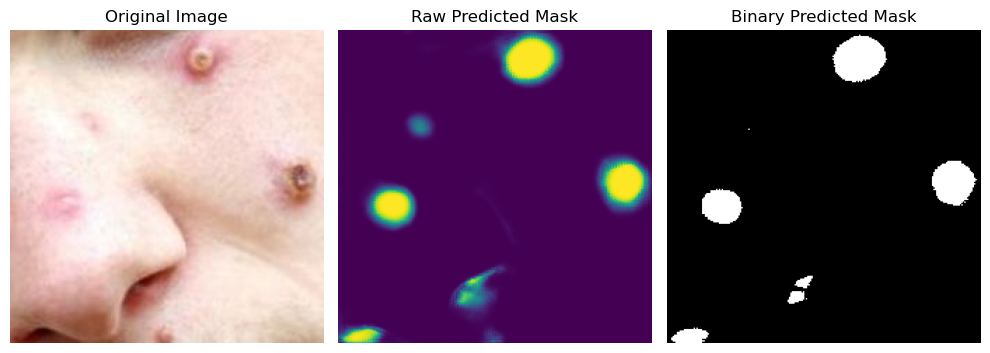

In [68]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Load a single image function
def load_single_image(image_path, img_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, img_size)
   # image = image / 255.0  # Normalize to [0, 1] if required
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict mask for a single image
def predict_mask(model, image_path):
    # Load and preprocess the image
    image_input = load_single_image(image_path)

    # Predict the mask
    predicted_mask_raw = model.predict(image_input)

    # Apply threshold to get binary mask
    threshold = 0.5  # Adjust if necessary
    predicted_mask_binary = (predicted_mask_raw[0] > threshold).astype(np.uint8)

    return predicted_mask_raw[0], predicted_mask_binary

# Custom Dice coefficient
def DiceMetric():
    def dice_coef(y_true, y_pred):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)
    return dice_coef

# Custom IOU Metric
def IoUMetric():
    def iou_coef(y_true, y_pred):
        intersection = tf.keras.backend.sum(y_true * y_pred)
        union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
        return (intersection + 1e-6) / (union + 1e-6)
    return iou_coef

# Load the saved U-Net model with custom_objects for dice_coef and iou_coef
model_path = "best_unet_custom.keras"
unet_model = load_model(model_path, custom_objects={'dice_coef': DiceMetric(), 'iou_coef': IoUMetric()})

# Predict on a single image
image_path = 'mkp_100.jpg'  # Define your image path here
predicted_mask_raw, predicted_mask_binary = predict_mask(unet_model, image_path)

# Visualize the results
def visualize_single_prediction(original_image_path, predicted_mask_raw, predicted_mask_binary):
    # Load the original image for visualization
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask_raw,)
    plt.title("Raw Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask_binary, cmap='gray')
    plt.title("Binary Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the predictions
visualize_single_prediction(image_path, predicted_mask_raw, predicted_mask_binary)
